# Monte Carlo Testing for Proxy Finder Algorithm


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import sys
from gain import GAIN
from usage_example import *
import utils
import models
import matplotlib.pyplot as plt

In [ ]:
def proxy_finder_validate(item, candidates, df1, df2, predictors, orthogonal_vars):
    # validate proxies and st item
    assert item in df1.columns, f'AssertionError: item {item} not in df1.columns'

    assert predictors, f'AssertionError: missing predictors. If you would prefer to not specify predictors, do not pass in a variable.'

    for c in predictors:
        assert c in df1.columns, f'AssertionError: predictor {c} not in df1.columns'
        assert c in df2.columns, f'AssertionError: predictor {c} not in df2.columns' # we need same variable in second dataset
        assert c in df1.select_dtypes(include=['number']).columns, f'predictor {c} is not a numeric column in df1'
        assert c in df2.select_dtypes(include=['number']).columns, f'predictor {c} is not a numeric column in df2'

    for c in candidates:
        assert c in df2.columns, f'AssertionError: candidate {c} not in df2.columns'

    if (orthogonal_vars != None):
        for c in orthogonal_vars:
            assert c in df2.columns, f'AssertionError: orthogonal variable {c} not in df2.columns'

In [ ]:
def get_predictions(df_train, df_test, predictors, target, epochs=50, learning_rate=0.001, l2_lambda=0.001):
  # CODE IMPLEMENTATION ASSISTED BY GENERATIVE AI

  # Set parameters
  SEED = 13
  DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
  TRAIN_SIZE = 1.0  # Using all of df1 for training
  np.random.seed(SEED)

  df1 = df_train.copy()
  df2 = df_test.copy()

  # drop everything but predictors and target from df1
  target_col_df1 = df1[target]
  df1 = df1[predictors]
  df1[target] = target_col_df1

  # drop everything but predictors from df2
  df2 = df2[predictors]
  # add missing target
  df2[target] = np.nan

  combined_df = pd.concat([df1, df2])

  # Step 3: Normalize the data
  scaler = MinMaxScaler()
  combined_data_std = scaler.fit_transform(combined_df)

  # Split back into df1 (training) and df2 (prediction)
  df1_std = combined_data_std[:len(df1)]
  df2_std = combined_data_std[len(df1):]

  # Create tensors and masks
  X_train_tensor = torch.tensor(df1_std).float()
  M_train_tensor = get_mask(X_train_tensor)  # This creates mask with 0s for observed values, 1s for missing values
  train_dataset = TensorDataset(X_train_tensor, M_train_tensor)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=False)

  X_test_tensor = torch.tensor(df2_std).float()
  M_test_tensor = get_mask(X_test_tensor)  # This will mark all values in the target column as missing
  test_dataset = TensorDataset(X_test_tensor, M_test_tensor)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

  # Step 4: Initialize and train the GAIN model
  stopper = EarlyStopper(patience=2, min_delta=0.001)
  model = GAIN(train_loader=train_loader, seed=SEED)

  optimizer_G = torch.optim.Adam(model.G.parameters())
  optimizer_D = torch.optim.Adam(model.D.parameters())
  model.set_optimizer(optimizer=optimizer_G, generator=True)
  model.set_optimizer(optimizer=optimizer_D, generator=False)

  model.to(DEVICE)
  model.train(n_epoches=100, verbose=True, stopper=stopper)

  # Step 5: Use the trained model to predict (impute) target values for df2
  predictions = []

  for x_test_batch, m_batch in test_loader:
      x_batch_imputed = model.imputation(x=x_test_batch, m=m_batch)
      x_batch_imputed = x_batch_imputed.cpu().numpy()
      predictions.append(x_batch_imputed)

  # Combine predictions and inverse transform
  predictions_combined = np.vstack(predictions)
  predictions_original_scale = scaler.inverse_transform(predictions_combined)

  # Extract the target column predictions
  target_column_index = df1.columns.get_loc(target)
  df2_predictions = predictions_original_scale[:, target_column_index]

  return df2_predictions

In [ ]:
# get predictions from the Torch neural network
def get_predictionsTorch(df_train, df_test, predictors, target, epochs=100, learning_rate=0.001, l2_lambda=0.001):
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import torch.nn.functional as F

    # split data for training and testing.
    training_features, validation_features, training_target, validation_target = train_test_split(df_train[predictors].to_numpy(), df_train[target].to_numpy(), test_size=0.2, random_state=42)

    training_features = torch.FloatTensor(training_features)
    training_target = torch.FloatTensor(training_target)
    validation_features = torch.FloatTensor(validation_features)
    validation_target = torch.FloatTensor(validation_target)

    model = nn.Sequential(
        nn.Linear(len(predictors), 64),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(32, 1)
    )

    # Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

    # MSE loss
    loss_func = nn.MSELoss()

    # train the model
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Forward pass
        prediction = model(training_features)
        loss = loss_func(prediction, training_target.unsqueeze(1))

        # Backward pass
        loss.backward()
        optimizer.step()

    # get predictions
    model.eval()
    test_data = torch.FloatTensor(df_test[predictors].to_numpy())

    with torch.no_grad():
        predictions = model(test_data)
        predictions = predictions.numpy().flatten()

        val_predictions = model(validation_features)
        val_predictions = val_predictions.numpy().flatten()


    # exit if correlation between predictions and item is bad
    mse = mean_squared_error(val_predictions, validation_target)
    print(f"Debug statement: Neural Net test MSE = {mse}") ####DEBUG
    if (mse > 0.03):
        print('Input Error: Predictors cannot predict {target} in df1', file=sys.stderr)
        print('Aborting program')
        sys.exit(-1)

    return predictions

In [ ]:
 # orthogonalization method
# all data is preprocessed and df test has been appended target preds
def orthogonalize(candidates, df_test, orthogonal_vars):
        orth_scores = {}
        for c in candidates:
            candset = df_test[[c, 'predicted_target']].copy().dropna() # assumes candidate has mostly non-NaN entries
            candcol = candset[c]

            X = sm.add_constant(candcol)
            temp_orth_scores = []
            for orth_var in orthogonal_vars:
                orthset = df_test[[orth_var]].copy().dropna()
                common_indices = candset.index.intersection(orthset.index)
                if common_indices.empty:
                    continue
                orth_col = orthset.loc[common_indices, orth_var]
                if np.var(orth_col) == 0:
                    print("ortho:", orth_var, "candidate", c)
                    continue # zero variance leads to divide by zero error
                candcol_common = candset.loc[common_indices, c]

                X_common = sm.add_constant(candcol_common)
                model = sm.OLS(orth_col, X_common).fit()
                temp_orth_scores.append(model.rsquared)

            if temp_orth_scores:
                orth_scores[c] = sum(temp_orth_scores) / len(temp_orth_scores)
            else:
                orth_scores[c] = 0
        return orth_scores

In [ ]:
def proxy_finder(df_train, df_test, target, predictors, num_proxies=1, orth_weight=0.65, candidates=None, orthogonal_vars=None, neural_net="original", drop=True):
    if candidates is None:
        candidates = list(df_test.select_dtypes(include='number').columns) #only numerical data (don't encode categories, make user do that)


    proxy_finder_validate(target, candidates, df_train, df_test, predictors, orthogonal_vars)

    #print(f"Predictors: {predictors}") #DEBUGDEBUGDEBUG------------------------------------------------------------
    #print(f"Candidates: {candidates}")

    df_train = data_rescale(df_train, predictors, target, drop)
    df_test = data_rescale(df_test, predictors, target, drop)
    # drop any rows that are missing data from target
    df_train = df_train.dropna(subset=target)

    if neural_net == "torch":
      predicted_scores = get_predictionsTorch(df_train, df_test, predictors, target)
    else:
      predicted_scores = get_predictions(df_train, df_test, predictors, target)


    df_test['predicted_target'] = predicted_scores
    #print(f"Predicted scores: {predicted_scores[:10]}")  #DEBUG DEBUG------------------------------------------------------------

    results = {}

    for c in candidates:
        candset = df_test[[c, 'predicted_target']].copy().dropna()
        if candset.empty:
            continue

        pred_scores = candset['predicted_target']
        candcol = candset[c]

        X_pred = sm.add_constant(candcol)
        model_pred = sm.OLS(pred_scores, X_pred).fit()
        results[c] = {
            'R_squared': model_pred.rsquared,
            'p_value': model_pred.pvalues.iloc[1],
            'coef': model_pred.params.iloc[1]
        }
        #print(f"candidate {c}: Results: {results}")  # Debug statement------------------------------------------------------------

    best_proxies = []

    if orthogonal_vars:
        orth_scores = orthogonalize(candidates, df_test, orthogonal_vars)
        proxy_scores = {}
        for c in candidates:
            try:
                proxy_scores[c] = (c, (1 - orth_weight) * results[c]['R_squared'] - orth_weight * orth_scores[c])
            except KeyError as e:
                continue

        sorted_results = sorted(proxy_scores.values(), key=lambda x: x[1], reverse=True)

        for i in range(min(num_proxies, len(sorted_results))):
            proxy, score = sorted_results[i]
            best_proxies.append(proxy)
            print(f"Proxy {i+1} for {target}: {proxy} with score: {score}")
    else:
        sorted_results = sorted(results.items(), key=lambda x: (-x[1]['R_squared'], x[1]['p_value']))

        for i in range(min(num_proxies, len(sorted_results))):
            proxy, metrics = sorted_results[i]
            best_proxies.append(proxy)
            print(f"Proxy {i+1} for {target}: {proxy} with R_squared: {metrics['R_squared']} and p_value: {metrics['p_value']}")

    return best_proxies

In [ ]:
# return a new df that is a copy of df, with: rescale all columns to be
#  between 0 and 1, inclusive. Drop any non-numeric columns. Drop any
# rows that are missing at least one predictor.
def data_rescale(df, predictors, target, drop=True):
    df = df.copy() # preserve immutability

    # Select only the numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns

    if drop:
      # drop any rows that are missing at least one predictor
      df = df.dropna(subset=predictors)

    # print('the dataframe we\'re rescaling is size: ') # debug
    # Initialize the scaler
    scaler = MinMaxScaler()

    # Fit the scaler to the data and transform it
    scaled_values = scaler.fit_transform(df[numeric_cols])

    # Create a new DataFrame with the scaled values, maintaining the original column names
    scaled_df = pd.DataFrame(scaled_values, columns=numeric_cols, index=df.index)

    return scaled_df

In [ ]:
def generate_synthetic_proxies(target_column, target_correlation, noise_level=0.1):

   # Convert target_column to numpy array and standardize
    target = np.array(target_column)
    length = len(target)

    target = (target - np.mean(target)) / np.std(target)

    synthetic_proxies = {}

    # Generate independent standard normal variable
    z = np.random.standard_normal(length)

    # Create correlated variable using the correlation formula
    proxy = target_correlation * target + np.sqrt(1 - target_correlation**2) * z

    # Add controlled noise
    proxy = proxy + np.random.normal(0, noise_level, length)

    # Standardize final proxy
    proxy = (proxy - np.mean(proxy)) / np.std(proxy)

    synthetic_proxies[f'proxy_{target_correlation:.2f}'] = proxy

    return synthetic_proxies

In [ ]:
def prepare_dataset(df, target, target_correlation):
  # split dataset in half
  df_train = df.sample(frac=0.5, random_state=42)
  df_test = df.drop(df_train.index)

  # add synthetic proxies to test set
  target_column = df_test[target]
  synthetic_proxies = generate_synthetic_proxies(target_column, target_correlation)
  for name, proxy in synthetic_proxies.items():
    df_test[name] = proxy

  # drop target from test set
  df_test = df_test.drop(columns=[target])

  return df_train, df_test

# Stage 1: Testing Mean Penalty Approach with Several Target Correlations

In [ ]:
def run_and_visualize_monte_carlo(df, weights, num_iterations, target, target_correlations, predictors, neural_net, drop):
    selection_trackers = []
    proxy_names = []

    # Run Monte Carlo for each target correlation
    for target_correlation in target_correlations:
        # Prepare dataset
        df_train, df_test = prepare_dataset(df, target, target_correlation) #######
        selection_tracker = {orth_weight: {} for orth_weight in weights}

        # Run iterations for each weight
        for orth_weight in weights:
            print(f"Testing with orthogonality weight: {orth_weight}")
            print(f"Testing with target correlation: {target_correlation}")

            for i in range(num_iterations):
                print(f"Running iteration {i+1}/{num_iterations}")
                top_proxies = proxy_finder(df_train=df_train,
                                         df_test=df_test,
                                         target=target,
                                         predictors=predictors,
                                         num_proxies=5,
                                         orth_weight=orth_weight,
                                         orthogonal_vars=predictors,
                                         neural_net=neural_net,
                                         )

                # Update selection tracker for top pick
                for rank, proxy in enumerate(top_proxies, 1):
                    if rank == 1:
                        selection_tracker[orth_weight][proxy] = selection_tracker[orth_weight].get(proxy, 0) + 1

        selection_trackers.append(selection_tracker)
        proxy_names.append(f'proxy_{target_correlation:.2f}')



    # SAVE TO CSV --------------------
    data = []

    for target_correlation, selection_tracker in zip(proxy_names, selection_trackers):
        for orth_weight, proxies in selection_tracker.items():
            for proxy, count in proxies.items():
                data.append({
                    'Target Correlation': target_correlation,
                    'Orthogonality Weight': orth_weight,
                    'Proxy': proxy,
                    'Count': count
                })

    df_selection_tracker = pd.DataFrame(data)
    df_selection_tracker.to_csv('selection_tracker.csv', index=False)
    # SAVE TO CSV --------------------


    # # Visualization
    # plt.figure(figsize=(10, 6))

    # # Plot results for each target correlation
    # for index, tracker in enumerate(selection_trackers):
    #     results = []
    #     for orth_weight, proxies in tracker.items():
    #         for proxy, frequency in proxies.items():
    #             results.append({
    #                 'orth_weight': orth_weight,
    #                 'proxy': proxy,
    #                 'frequency': (frequency / num_iterations) * 100
    #             })

    #     results_df = pd.DataFrame(results)
    #     pivot_data = results_df.pivot(index='orth_weight', columns='proxy', values='frequency')
    #     pivot_data.fillna(0, inplace=True)
    #     print(pivot_data)

    #     # Plot each proxy as a separate line
    #     name = proxy_names[index]
    #     plt.plot(pivot_data.index, pivot_data[name], marker='o', label=name, linewidth=2)

    # # Create the line plot
    # plt.xlabel('Orthogonality Weight')
    # plt.ylabel('Selection Frequency')
    # plt.title('Selection Frequency vs Orthogonality Weight')
    # plt.grid(True, linestyle='--', alpha=0.7)
    # plt.legend()
    # plt.show()

In [ ]:
# change parameters as needed
df = pd.read_stata("/content/temp_yougov.dta")
# weights = [0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55]
weights = [0.65]
target_correlations = [0.90]
num_iterations = 5
target = 'christian_nationalism'
predictors = [
                   'presvote20post',
                   'housevote20post',
                   'senvote20post',
                   'pff_jb',
                   'pff_dt',
                   'pid7',
                   'election_fairnness',
                   'educ',
                   'hispanic',
                   'partisan_violence',
                   'immigrant_citizenship',
                   'immigrant_deport',
                   'auth_grid_1',
                   'auth_grid_3',
                   'auth_grid_2',
                   'faminc_new']
# V202532
run_and_visualize_monte_carlo(df, weights, num_iterations, target, target_correlations, predictors, "GAIN", True)

Testing with orthogonality weight: 0.65
Testing with target correlation: 0.9
Running iteration 1/5


Epoch 99: 100%|██████████| 14/14 [00:00<00:00, 38.54batch/s, mse_test=nan, mse_train=0.0182]


Proxy 1 for christian_nationalism: auth_grid_1 with score: 0.043879877980376805
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.04316022799832567
Proxy 3 for christian_nationalism: immigrant_deport with score: 0.040138405928780485
Proxy 4 for christian_nationalism: immigrant_citizenship with score: 0.03627107053288492
Proxy 5 for christian_nationalism: ideo7 with score: 0.02065372585528094
Running iteration 2/5


Epoch 34:  86%|████████▌ | 12/14 [00:00<00:00, 54.46batch/s, mse_test=nan, mse_train=0.0376]


KeyboardInterrupt: 

# Stage 2: Testing Threshold-Based Penalty Approach with Several Tau Values


In [ ]:
from proxy_finder_threshold_orthogonalization1 import proxy_finder_threshold_ortho as pf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.015790658249321195
Proxy 1 for christian_nationalism: christian_nationalism with score: 0.03886556131412594
Proxy 2 for christian_nationalism: index with score: 0.00249156039780819
Proxy 3 for christian_nationalism: hispanic with score: 0.0009433580646889039
Proxy 4 for christian_nationalism: auth_grid_1 with score: -0.006496961107809562
Proxy 5 for christian_nationalism: auth_grid_3 with score: -0.011481241975279985
Proxy 6 for christian_nationalism: ideo7 with score: -0.013375356616428025
Proxy 7 for christian_nationalism: pff_dt with score: -0.016776623171550487
Proxy 8 for christian_nationalism: immigrant_deport with score: -0.021799249569553203
Proxy 9 for christian_nationalism: auth_grid_2 with score: -0.02539523247065939
Proxy 10 for christian_nationalism: white with score: -0.03193742053904329
Proxy 11 for christian_nationalism: turnout20post with score: -0.

In [ ]:
def run_and_visualize_monte_carlo2(df, weights, num_iterations, target, target_correlation, predictors, taus):
    selection_trackers = []
    proxy_name = (f'proxy_{target_correlation:.2f}')
    tau_names = [f'tau_{tau:.2f}' for tau in taus]

    # Run Monte Carlo for each target correlation
    for tau in taus:
        # Prepare dataset
        df_train, df_test = prepare_dataset(df, target, target_correlation)
        selection_tracker = {orth_weight: {} for orth_weight in weights}

        # Run iterations for each weight
        for orth_weight in weights:
            print(f"Testing with orthogonality weight: {orth_weight}")
            print(f"Testing with tau: {tau}")

            for i in range(num_iterations):
                print(f"Running iteration {i+1}/{num_iterations}")
                top_proxies = pf(df_train=df_train,
                                         df_test=df_test,
                                         target=target,
                                         predictors=predictors,
                                         num_proxies=5,
                                         orth_weight=orth_weight,
                                         orthogonal_vars=predictors)

                # Update selection tracker for top pick
                for rank, proxy in enumerate(top_proxies, 1):
                    if rank == 1:
                        selection_tracker[orth_weight][proxy] = selection_tracker[orth_weight].get(proxy, 0) + 1

        selection_trackers.append(selection_tracker)

    # Visualization
    plt.figure(figsize=(10, 6))

    # Plot results for each target correlation
    for index, tracker in enumerate(selection_trackers):
        results = []
        for orth_weight, proxies in tracker.items():
            for proxy, frequency in proxies.items():
                results.append({
                    'orth_weight': orth_weight,
                    'proxy': proxy,
                    'frequency': (frequency / num_iterations) * 100
                })

        results_df = pd.DataFrame(results)
        pivot_data = results_df.pivot(index='orth_weight', columns='proxy', values='frequency')
        pivot_data.fillna(0, inplace=True)
        print(pivot_data)

        # Plot each proxy as a separate line
        name = tau_names[index]
        plt.plot(pivot_data.index, pivot_data[proxy_name], marker='o', label=name, linewidth=2)

    # Create the line plot
    plt.xlabel('Orthogonality Weight')
    plt.ylabel('Selection Frequency')
    plt.title('Selection Frequency vs Orthogonality Weight')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

Testing with orthogonality weight: 0.4
Testing with tau: 0.0
Running iteration 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017678916113245288
Proxy 1 for christian_nationalism: pff_dt with score: 0.25640196561651524
Proxy 2 for christian_nationalism: presvote20post with score: 0.2289237540324809
Proxy 3 for christian_nationalism: proxy_0.90 with score: 0.22339841142516176
Proxy 4 for christian_nationalism: immigrant_deport with score: 0.2170973605768162
Proxy 5 for christian_nationalism: senvote20post with score: 0.21099390145580538
Running iteration 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017532541427914515
Proxy 1 for christian_nationalism: pff_dt with score: 0.27468780945900645
Proxy 2 for christian_nationalism: presvote20post with score: 0.2442451314760794
Proxy 3 for christian_nationalism: senvote20post with score: 0.23542643514559053
Proxy 4 for christian_nationalism: housevote20post with score: 0.23492017273407528
Proxy 5 for christian_nationalism: proxy_0.90 with score: 0.22150511635059955
Running iteration 3/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01727082662932807
Proxy 1 for christian_nationalism: pff_dt with score: 0.25006309640249635
Proxy 2 for christian_nationalism: presvote20post with score: 0.2331165288137444
Proxy 3 for christian_nationalism: senvote20post with score: 0.22715399153312682
Proxy 4 for christian_nationalism: housevote20post with score: 0.22482130735710876
Proxy 5 for christian_nationalism: proxy_0.90 with score: 0.22036566202087443
Running iteration 4/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017828406493834003
Proxy 1 for christian_nationalism: presvote20post with score: 0.2462968567352421
Proxy 2 for christian_nationalism: pff_dt with score: 0.2382116006025406
Proxy 3 for christian_nationalism: senvote20post with score: 0.23812321157258198
Proxy 4 for christian_nationalism: housevote20post with score: 0.23376386807318295
Proxy 5 for christian_nationalism: ideo7 with score: 0.21698375633331551
Running iteration 5/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01807044183277217
Proxy 1 for christian_nationalism: pff_dt with score: 0.2579507750144261
Proxy 2 for christian_nationalism: presvote20post with score: 0.22542130255202852
Proxy 3 for christian_nationalism: proxy_0.90 with score: 0.21615010988109273
Proxy 4 for christian_nationalism: senvote20post with score: 0.21384475279004717
Proxy 5 for christian_nationalism: housevote20post with score: 0.21346378744190792
Testing with orthogonality weight: 0.45
Testing with tau: 0.0
Running iteration 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017569167027675473
Proxy 1 for christian_nationalism: pff_dt with score: 0.1901713536402293
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.18009122402139388
Proxy 3 for christian_nationalism: presvote20post with score: 0.178156190360605
Proxy 4 for christian_nationalism: senvote20post with score: 0.17224959181606697
Proxy 5 for christian_nationalism: housevote20post with score: 0.16892000241201316
Running iteration 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01702735859395514
Proxy 1 for christian_nationalism: pff_dt with score: 0.2047098347484811
Proxy 2 for christian_nationalism: presvote20post with score: 0.17972985887261275
Proxy 3 for christian_nationalism: proxy_0.90 with score: 0.17905843012137607
Proxy 4 for christian_nationalism: senvote20post with score: 0.17438213838964178
Proxy 5 for christian_nationalism: housevote20post with score: 0.1733587416326549
Running iteration 3/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Debug statement: Neural Net test MSE = 0.017946673957741348
Proxy 1 for christian_nationalism: pff_dt with score: 0.20151322543808342
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.18344836882180393
Proxy 3 for christian_nationalism: immigrant_deport with score: 0.1633906433557399
Proxy 4 for christian_nationalism: presvote20post with score: 0.16184616563815582
Proxy 5 for christian_nationalism: ideo7 with score: 0.1608748485395389
Running iteration 4/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01735203147158507
Proxy 1 for christian_nationalism: pff_dt with score: 0.20730051088724255
Proxy 2 for christian_nationalism: presvote20post with score: 0.1737357957734497
Proxy 3 for christian_nationalism: senvote20post with score: 0.17254765432482994
Proxy 4 for christian_nationalism: election_fairnness with score: 0.17067041262654864
Proxy 5 for christian_nationalism: immigrant_deport with score: 0.17061528259462758
Running iteration 5/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.018546486441886313
Proxy 1 for christian_nationalism: pff_dt with score: 0.20233108032914582
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.18025892576351232
Proxy 3 for christian_nationalism: presvote20post with score: 0.17299181645349962
Proxy 4 for christian_nationalism: senvote20post with score: 0.16740059795039774
Proxy 5 for christian_nationalism: housevote20post with score: 0.16543046435407466
Testing with orthogonality weight: 0.5
Testing with tau: 0.0
Running iteration 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017035042957472244
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.13972528991673
Proxy 2 for christian_nationalism: immigrant_deport with score: 0.12755437442899986
Proxy 3 for christian_nationalism: pff_dt with score: 0.12223809051076345
Proxy 4 for christian_nationalism: ideo7 with score: 0.11862676661103838
Proxy 5 for christian_nationalism: election_fairnness with score: 0.1077944571392051
Running iteration 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017520753616083753
Proxy 1 for christian_nationalism: pff_dt with score: 0.14326062446718624
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.13944606911075702
Proxy 3 for christian_nationalism: presvote20post with score: 0.12871537135183905
Proxy 4 for christian_nationalism: housevote20post with score: 0.12446191768965464
Proxy 5 for christian_nationalism: senvote20post with score: 0.1243007375521063
Running iteration 3/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017558467145331505
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.13858485760080036
Proxy 2 for christian_nationalism: pff_dt with score: 0.13780486043289658
Proxy 3 for christian_nationalism: immigrant_deport with score: 0.12336899779017613
Proxy 4 for christian_nationalism: ideo7 with score: 0.12024153963465262
Proxy 5 for christian_nationalism: presvote20post with score: 0.11726980122731293
Running iteration 4/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.018367673232414342
Proxy 1 for christian_nationalism: pff_dt with score: 0.14539773416927376
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.13610761059181636
Proxy 3 for christian_nationalism: presvote20post with score: 0.12235180595892245
Proxy 4 for christian_nationalism: ideo7 with score: 0.11768582858568938
Proxy 5 for christian_nationalism: election_fairnness with score: 0.11718977382946599
Running iteration 5/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017114488269950885
Proxy 1 for christian_nationalism: pff_dt with score: 0.15038385109185587
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.14063787440121495
Proxy 3 for christian_nationalism: ideo7 with score: 0.11897560879024155
Proxy 4 for christian_nationalism: immigrant_deport with score: 0.11598959906244027
Proxy 5 for christian_nationalism: presvote20post with score: 0.11246171868047447
Testing with orthogonality weight: 0.55
Testing with tau: 0.0
Running iteration 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017435408668077253
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.09897614346681494
Proxy 2 for christian_nationalism: pff_dt with score: 0.0911804555456214
Proxy 3 for christian_nationalism: ideo7 with score: 0.07727640305845901
Proxy 4 for christian_nationalism: immigrant_deport with score: 0.0666413967757595
Proxy 5 for christian_nationalism: presvote20post with score: 0.062378324678114105
Running iteration 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017079322763369258
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.10077172079213981
Proxy 2 for christian_nationalism: pff_dt with score: 0.09327558651735471
Proxy 3 for christian_nationalism: ideo7 with score: 0.07730868500595389
Proxy 4 for christian_nationalism: immigrant_deport with score: 0.06742341850637049
Proxy 5 for christian_nationalism: presvote20post with score: 0.06013358929326457
Running iteration 3/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01848507248064373
Proxy 1 for christian_nationalism: pff_dt with score: 0.10128310403208127
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.09929587059455416
Proxy 3 for christian_nationalism: ideo7 with score: 0.07583681298194933
Proxy 4 for christian_nationalism: immigrant_deport with score: 0.07405417201025333
Proxy 5 for christian_nationalism: presvote20post with score: 0.06046267062420835
Running iteration 4/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01841845522106443
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.0970409541585846
Proxy 2 for christian_nationalism: pff_dt with score: 0.0880455079567318
Proxy 3 for christian_nationalism: ideo7 with score: 0.07537112071206359
Proxy 4 for christian_nationalism: immigrant_deport with score: 0.07247956950943218
Proxy 5 for christian_nationalism: election_fairnness with score: 0.06629012032520412
Running iteration 5/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01737554336032942
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.10002176846478247
Proxy 2 for christian_nationalism: pff_dt with score: 0.08535432332996432
Proxy 3 for christian_nationalism: immigrant_deport with score: 0.08432087115802522
Proxy 4 for christian_nationalism: ideo7 with score: 0.07421468317138341
Proxy 5 for christian_nationalism: auth_grid_1 with score: 0.04954770853016913
Testing with orthogonality weight: 0.6
Testing with tau: 0.0
Running iteration 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017208514807916298
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.05828467546296465
Proxy 2 for christian_nationalism: pff_dt with score: 0.041535144091066345
Proxy 3 for christian_nationalism: ideo7 with score: 0.03716869942313211
Proxy 4 for christian_nationalism: immigrant_deport with score: 0.03246089334868835
Proxy 5 for christian_nationalism: auth_grid_3 with score: 0.021170614643563346
Running iteration 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Debug statement: Neural Net test MSE = 0.019160672504647314
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.06087899194982735
Proxy 2 for christian_nationalism: immigrant_deport with score: 0.03664727469565621
Proxy 3 for christian_nationalism: auth_grid_1 with score: 0.03348009827907153
Proxy 4 for christian_nationalism: ideo7 with score: 0.029804036453566995
Proxy 5 for christian_nationalism: pff_dt with score: 0.017642526687990157
Running iteration 3/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01779026980714203
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.0572917844493486
Proxy 2 for christian_nationalism: pff_dt with score: 0.03738934587043058
Proxy 3 for christian_nationalism: ideo7 with score: 0.0365556775903203
Proxy 4 for christian_nationalism: immigrant_deport with score: 0.02455258731697421
Proxy 5 for christian_nationalism: auth_grid_1 with score: 0.021709544664854308
Running iteration 4/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01757376708762248
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.05851484150098221
Proxy 2 for christian_nationalism: pff_dt with score: 0.040337340058393845
Proxy 3 for christian_nationalism: ideo7 with score: 0.034271137221093206
Proxy 4 for christian_nationalism: immigrant_deport with score: 0.03198558521303371
Proxy 5 for christian_nationalism: auth_grid_1 with score: 0.028239258488887087
Running iteration 5/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.016940668255090493
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.0585134102885273
Proxy 2 for christian_nationalism: pff_dt with score: 0.04034198560266222
Proxy 3 for christian_nationalism: immigrant_deport with score: 0.03289350552174192
Proxy 4 for christian_nationalism: ideo7 with score: 0.032109976679161295
Proxy 5 for christian_nationalism: auth_grid_1 with score: 0.02634858623295523
Testing with orthogonality weight: 0.6499999999999999
Testing with tau: 0.0
Running iteration 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017567131940832974
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.017021217135736122
Proxy 2 for christian_nationalism: index with score: 0.001385759268741749
Proxy 3 for christian_nationalism: auth_grid_1 with score: -0.00494618065415324
Proxy 4 for christian_nationalism: immigrant_deport with score: -0.009767212547609622
Proxy 5 for christian_nationalism: pff_dt with score: -0.013499760193763866
Running iteration 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01737318349920511
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.02057672524823817
Proxy 2 for christian_nationalism: auth_grid_1 with score: 0.007600906771027829
Proxy 3 for christian_nationalism: index with score: 0.0011732586774696188
Proxy 4 for christian_nationalism: auth_grid_3 with score: -0.0013384127927600908
Proxy 5 for christian_nationalism: ideo7 with score: -0.015110663782225947
Running iteration 3/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.018858155016311537
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.017747402078886226
Proxy 2 for christian_nationalism: index with score: 0.0012955353659845018
Proxy 3 for christian_nationalism: auth_grid_3 with score: -0.007606040732343999
Proxy 4 for christian_nationalism: auth_grid_1 with score: -0.007792382968937847
Proxy 5 for christian_nationalism: ideo7 with score: -0.009220789578448657
Running iteration 4/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017457246369290164
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.016356938518271358
Proxy 2 for christian_nationalism: auth_grid_1 with score: 0.004464790457353318
Proxy 3 for christian_nationalism: index with score: 0.0021067296675951314
Proxy 4 for christian_nationalism: immigrant_deport with score: -0.003538022323479467
Proxy 5 for christian_nationalism: auth_grid_3 with score: -0.004319845390733365
Running iteration 5/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017181142552640204
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.0216928177140151
Proxy 2 for christian_nationalism: auth_grid_1 with score: 0.005979153103438856
Proxy 3 for christian_nationalism: auth_grid_3 with score: 0.0020355838344808114
Proxy 4 for christian_nationalism: index with score: 0.0007690999750974316
Proxy 5 for christian_nationalism: immigrant_deport with score: -0.003806802714651558
Testing with orthogonality weight: 0.7
Testing with tau: 0.0
Running iteration 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01708635359369735
Proxy 1 for christian_nationalism: index with score: 0.0007980160921479463
Proxy 2 for christian_nationalism: auth_grid_1 with score: -0.01266233327151825
Proxy 3 for christian_nationalism: auth_grid_3 with score: -0.020189156390976362
Proxy 4 for christian_nationalism: proxy_0.90 with score: -0.020630293599824878
Proxy 5 for christian_nationalism: educ with score: -0.031323454723777934
Running iteration 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.019269496298894205
Proxy 1 for christian_nationalism: index with score: 0.0009112859652563478
Proxy 2 for christian_nationalism: auth_grid_1 with score: -0.017290524212293087
Proxy 3 for christian_nationalism: proxy_0.90 with score: -0.020807749478423593
Proxy 4 for christian_nationalism: auth_grid_3 with score: -0.024056215563362904
Proxy 5 for christian_nationalism: educ with score: -0.03297589213519948
Running iteration 3/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017573078165275563
Proxy 1 for christian_nationalism: index with score: 0.0008540491286499475
Proxy 2 for christian_nationalism: proxy_0.90 with score: -0.021332846522981674
Proxy 3 for christian_nationalism: auth_grid_1 with score: -0.022252081815554978
Proxy 4 for christian_nationalism: auth_grid_3 with score: -0.026515922233361744
Proxy 5 for christian_nationalism: educ with score: -0.03798835038941755
Running iteration 4/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017891220004546567
Proxy 1 for christian_nationalism: index with score: 0.0005172005495365007
Proxy 2 for christian_nationalism: auth_grid_3 with score: -0.021696692698151637
Proxy 3 for christian_nationalism: proxy_0.90 with score: -0.025499793666529325
Proxy 4 for christian_nationalism: auth_grid_1 with score: -0.035607004871146763
Proxy 5 for christian_nationalism: auth_grid_2 with score: -0.039638223999301024
Running iteration 5/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017475211249005602
Proxy 1 for christian_nationalism: index with score: 0.0009438922736915157
Proxy 2 for christian_nationalism: proxy_0.90 with score: -0.020026005583341583
Proxy 3 for christian_nationalism: auth_grid_1 with score: -0.02281138142942213
Proxy 4 for christian_nationalism: auth_grid_3 with score: -0.028650223206990857
Proxy 5 for christian_nationalism: educ with score: -0.03904492901797971
Testing with orthogonality weight: 0.4
Testing with tau: 0.05
Running iteration 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01689126664876995
Proxy 1 for christian_nationalism: pff_dt with score: 0.24515575925504196
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.22745083150048478
Proxy 3 for christian_nationalism: presvote20post with score: 0.22190464408915933
Proxy 4 for christian_nationalism: senvote20post with score: 0.21309798201549557
Proxy 5 for christian_nationalism: housevote20post with score: 0.2121388495975035
Running iteration 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01813675942679294
Proxy 1 for christian_nationalism: pff_dt with score: 0.28469895366883907
Proxy 2 for christian_nationalism: presvote20post with score: 0.24859596934889328
Proxy 3 for christian_nationalism: senvote20post with score: 0.24356499395736309
Proxy 4 for christian_nationalism: housevote20post with score: 0.24171903779318032
Proxy 5 for christian_nationalism: proxy_0.90 with score: 0.22099833865276652
Running iteration 3/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Debug statement: Neural Net test MSE = 0.01846630236843622
Proxy 1 for christian_nationalism: pff_dt with score: 0.27091552272751507
Proxy 2 for christian_nationalism: presvote20post with score: 0.2438794531887684
Proxy 3 for christian_nationalism: senvote20post with score: 0.2388245651668926
Proxy 4 for christian_nationalism: housevote20post with score: 0.2354909864711145
Proxy 5 for christian_nationalism: proxy_0.90 with score: 0.22268909972626044
Running iteration 4/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017329950432714233
Proxy 1 for christian_nationalism: pff_dt with score: 0.24063146367121452
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.22645663275613775
Proxy 3 for christian_nationalism: presvote20post with score: 0.21962503776301667
Proxy 4 for christian_nationalism: housevote20post with score: 0.21391927823803802
Proxy 5 for christian_nationalism: senvote20post with score: 0.21202826562356553
Running iteration 5/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.018408899041729456
Proxy 1 for christian_nationalism: pff_dt with score: 0.2563908553215597
Proxy 2 for christian_nationalism: presvote20post with score: 0.24403067876182816
Proxy 3 for christian_nationalism: senvote20post with score: 0.22996032415162782
Proxy 4 for christian_nationalism: housevote20post with score: 0.22895654132986681
Proxy 5 for christian_nationalism: proxy_0.90 with score: 0.22231316667914086
Testing with orthogonality weight: 0.45
Testing with tau: 0.05
Running iteration 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.018157776177663072
Proxy 1 for christian_nationalism: pff_dt with score: 0.20597153550723574
Proxy 2 for christian_nationalism: presvote20post with score: 0.18389300751183305
Proxy 3 for christian_nationalism: senvote20post with score: 0.1836302695715119
Proxy 4 for christian_nationalism: housevote20post with score: 0.17960260330726668
Proxy 5 for christian_nationalism: proxy_0.90 with score: 0.17784364888963733
Running iteration 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017817765681989683
Proxy 1 for christian_nationalism: pff_dt with score: 0.21067660656744053
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.18359252042050095
Proxy 3 for christian_nationalism: presvote20post with score: 0.1785683407311208
Proxy 4 for christian_nationalism: senvote20post with score: 0.16940760054211385
Proxy 5 for christian_nationalism: housevote20post with score: 0.1684937541371636
Running iteration 3/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01774812164849716
Proxy 1 for christian_nationalism: pff_dt with score: 0.22282688734199402
Proxy 2 for christian_nationalism: housevote20post with score: 0.18428923972301414
Proxy 3 for christian_nationalism: presvote20post with score: 0.1833186921538079
Proxy 4 for christian_nationalism: senvote20post with score: 0.18328486903605767
Proxy 5 for christian_nationalism: proxy_0.90 with score: 0.18174966321914693
Running iteration 4/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017730683368832774
Proxy 1 for christian_nationalism: pff_dt with score: 0.20152379142862498
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.1827540441222979
Proxy 3 for christian_nationalism: presvote20post with score: 0.1785228205832978
Proxy 4 for christian_nationalism: senvote20post with score: 0.1709216663500958
Proxy 5 for christian_nationalism: housevote20post with score: 0.17070344731943948
Running iteration 5/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01783340125765069
Proxy 1 for christian_nationalism: pff_dt with score: 0.20900447234218816
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.18744892481541414
Proxy 3 for christian_nationalism: presvote20post with score: 0.18219914069768664
Proxy 4 for christian_nationalism: senvote20post with score: 0.17484243733828247
Proxy 5 for christian_nationalism: housevote20post with score: 0.17411199580759562
Testing with orthogonality weight: 0.5
Testing with tau: 0.05
Running iteration 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017851366894953966
Proxy 1 for christian_nationalism: pff_dt with score: 0.1574327874209775
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.14453532117270135
Proxy 3 for christian_nationalism: presvote20post with score: 0.12429488603666886
Proxy 4 for christian_nationalism: ideo7 with score: 0.12096178146807418
Proxy 5 for christian_nationalism: housevote20post with score: 0.11566829185974647
Running iteration 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.016487630029274256
Proxy 1 for christian_nationalism: pff_dt with score: 0.14755649268627508
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.14341891920537042
Proxy 3 for christian_nationalism: ideo7 with score: 0.12414270868995664
Proxy 4 for christian_nationalism: immigrant_deport with score: 0.12359333794018501
Proxy 5 for christian_nationalism: presvote20post with score: 0.12047618124679058
Running iteration 3/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Debug statement: Neural Net test MSE = 0.017676082846004477
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.14579162477740343
Proxy 2 for christian_nationalism: pff_dt with score: 0.14062047193679655
Proxy 3 for christian_nationalism: ideo7 with score: 0.12037776403389294
Proxy 4 for christian_nationalism: immigrant_deport with score: 0.11358894444164447
Proxy 5 for christian_nationalism: presvote20post with score: 0.11253796515309691
Running iteration 4/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017358517514674248
Proxy 1 for christian_nationalism: pff_dt with score: 0.1482168476934551
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.1470461998252287
Proxy 3 for christian_nationalism: immigrant_deport with score: 0.12929247157499413
Proxy 4 for christian_nationalism: ideo7 with score: 0.12266142984823264
Proxy 5 for christian_nationalism: presvote20post with score: 0.11553932598354347
Running iteration 5/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017479954211816875
Proxy 1 for christian_nationalism: pff_dt with score: 0.15507658869304358
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.1461503450385373
Proxy 3 for christian_nationalism: presvote20post with score: 0.12437045879077466
Proxy 4 for christian_nationalism: ideo7 with score: 0.1234424669277227
Proxy 5 for christian_nationalism: immigrant_deport with score: 0.1173139318639701
Testing with orthogonality weight: 0.55
Testing with tau: 0.05
Running iteration 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017235483210519768
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.10326256846621551
Proxy 2 for christian_nationalism: pff_dt with score: 0.09763854088696386
Proxy 3 for christian_nationalism: immigrant_deport with score: 0.07823905049152402
Proxy 4 for christian_nationalism: ideo7 with score: 0.07105273958534836
Proxy 5 for christian_nationalism: presvote20post with score: 0.0540743120617479
Running iteration 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01786409058832475
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.10157310701114833
Proxy 2 for christian_nationalism: pff_dt with score: 0.07980906735844487
Proxy 3 for christian_nationalism: immigrant_deport with score: 0.07830877409238418
Proxy 4 for christian_nationalism: ideo7 with score: 0.07105833611093298
Proxy 5 for christian_nationalism: auth_grid_1 with score: 0.06086925224306222
Running iteration 3/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017800699355170136
Proxy 1 for christian_nationalism: pff_dt with score: 0.10130862303095131
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.10008476099743197
Proxy 3 for christian_nationalism: immigrant_deport with score: 0.0793665679628377
Proxy 4 for christian_nationalism: ideo7 with score: 0.07747661765739727
Proxy 5 for christian_nationalism: election_fairnness with score: 0.06938642208609039
Running iteration 4/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017687215347189277
Proxy 1 for christian_nationalism: pff_dt with score: 0.10572684002189561
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.10280464586689173
Proxy 3 for christian_nationalism: ideo7 with score: 0.07647242524300357
Proxy 4 for christian_nationalism: immigrant_deport with score: 0.07391618931260369
Proxy 5 for christian_nationalism: presvote20post with score: 0.06641384892715985
Running iteration 5/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Debug statement: Neural Net test MSE = 0.01830066602584438
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.10117038882651863
Proxy 2 for christian_nationalism: pff_dt with score: 0.08601593631848128
Proxy 3 for christian_nationalism: ideo7 with score: 0.07358858708302296
Proxy 4 for christian_nationalism: immigrant_deport with score: 0.06331666889489679
Proxy 5 for christian_nationalism: auth_grid_1 with score: 0.06307862190453617
Testing with orthogonality weight: 0.6
Testing with tau: 0.05
Running iteration 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.018395906605933647
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.06577800436542569
Proxy 2 for christian_nationalism: auth_grid_1 with score: 0.041125166348975783
Proxy 3 for christian_nationalism: ideo7 with score: 0.032884465556898085
Proxy 4 for christian_nationalism: pff_dt with score: 0.030492885715174833
Proxy 5 for christian_nationalism: immigrant_deport with score: 0.02942467188437986
Running iteration 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017308158339071098
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.06523820170033653
Proxy 2 for christian_nationalism: pff_dt with score: 0.044865456157082984
Proxy 3 for christian_nationalism: ideo7 with score: 0.03401123322504096
Proxy 4 for christian_nationalism: immigrant_deport with score: 0.03066268587216095
Proxy 5 for christian_nationalism: auth_grid_1 with score: 0.025601304939429734
Running iteration 3/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017405106505950913
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.061519309984386095
Proxy 2 for christian_nationalism: pff_dt with score: 0.0503657874172298
Proxy 3 for christian_nationalism: ideo7 with score: 0.03327540787100086
Proxy 4 for christian_nationalism: immigrant_deport with score: 0.024887326741696525
Proxy 5 for christian_nationalism: auth_grid_1 with score: 0.022124774940328912
Running iteration 4/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017690028898050207
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.0644758259902993
Proxy 2 for christian_nationalism: pff_dt with score: 0.039386265753559135
Proxy 3 for christian_nationalism: immigrant_deport with score: 0.03513074726243806
Proxy 4 for christian_nationalism: ideo7 with score: 0.030523434178117037
Proxy 5 for christian_nationalism: auth_grid_1 with score: 0.02907184344403793
Running iteration 5/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017878493153561735
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.061116109978230526
Proxy 2 for christian_nationalism: immigrant_deport with score: 0.037396018040020906
Proxy 3 for christian_nationalism: ideo7 with score: 0.035765416939599115
Proxy 4 for christian_nationalism: auth_grid_1 with score: 0.02774525770072822
Proxy 5 for christian_nationalism: pff_dt with score: 0.025723373959869678
Testing with orthogonality weight: 0.6499999999999999
Testing with tau: 0.05
Running iteration 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01778502354500671
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.02144181800964079
Proxy 2 for christian_nationalism: auth_grid_3 with score: 0.0016168551405054687
Proxy 3 for christian_nationalism: index with score: 0.0009023040692276554
Proxy 4 for christian_nationalism: auth_grid_1 with score: -0.003812244358979089
Proxy 5 for christian_nationalism: ideo7 with score: -0.011214918477523317
Running iteration 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01746611585435751
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.02117474993974866
Proxy 2 for christian_nationalism: index with score: 0.001277845925053112
Proxy 3 for christian_nationalism: immigrant_deport with score: 0.0011324156098824756
Proxy 4 for christian_nationalism: auth_grid_3 with score: -0.006338592793861911
Proxy 5 for christian_nationalism: ideo7 with score: -0.008731365798078983
Running iteration 3/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017919908886965482
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.02167113065375484
Proxy 2 for christian_nationalism: auth_grid_1 with score: 0.002636480739440686
Proxy 3 for christian_nationalism: index with score: 0.0009048690989518273
Proxy 4 for christian_nationalism: auth_grid_3 with score: -0.009396417816399355
Proxy 5 for christian_nationalism: ideo7 with score: -0.012526293882949902
Running iteration 4/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.019447091573079413
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.01779576677028291
Proxy 2 for christian_nationalism: index with score: 0.0007434590228580786
Proxy 3 for christian_nationalism: auth_grid_1 with score: -0.0009654151228259134
Proxy 4 for christian_nationalism: auth_grid_3 with score: -0.011044902607453985
Proxy 5 for christian_nationalism: ideo7 with score: -0.011267702327366985
Running iteration 5/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01707786430656805
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.022415482532126413
Proxy 2 for christian_nationalism: index with score: 0.0011908637241464517
Proxy 3 for christian_nationalism: auth_grid_3 with score: -0.000518815549341356
Proxy 4 for christian_nationalism: auth_grid_1 with score: -0.004674840901536817
Proxy 5 for christian_nationalism: ideo7 with score: -0.009250617524486415
Testing with orthogonality weight: 0.7
Testing with tau: 0.05
Running iteration 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017657229203485194
Proxy 1 for christian_nationalism: index with score: 0.0009995088102422224
Proxy 2 for christian_nationalism: proxy_0.90 with score: -0.018381789517143032
Proxy 3 for christian_nationalism: auth_grid_1 with score: -0.01980808632030799
Proxy 4 for christian_nationalism: auth_grid_3 with score: -0.026816996554303252
Proxy 5 for christian_nationalism: educ with score: -0.036896001036429954
Running iteration 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01697214782044943
Proxy 1 for christian_nationalism: index with score: 0.0009423241922532856
Proxy 2 for christian_nationalism: proxy_0.90 with score: -0.01928936103273901
Proxy 3 for christian_nationalism: auth_grid_3 with score: -0.022192528124993324
Proxy 4 for christian_nationalism: auth_grid_1 with score: -0.03369096735365379
Proxy 5 for christian_nationalism: auth_grid_2 with score: -0.03918002804863852
Running iteration 3/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01783491288414275
Proxy 1 for christian_nationalism: index with score: 0.0013575824512736092
Proxy 2 for christian_nationalism: proxy_0.90 with score: -0.019306406289717498
Proxy 3 for christian_nationalism: auth_grid_1 with score: -0.021478336196091713
Proxy 4 for christian_nationalism: auth_grid_3 with score: -0.02754544003155908
Proxy 5 for christian_nationalism: educ with score: -0.029454611450667016
Running iteration 4/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.016853266508744955
Proxy 1 for christian_nationalism: index with score: 0.0014330549987959132
Proxy 2 for christian_nationalism: proxy_0.90 with score: -0.016687766421354916
Proxy 3 for christian_nationalism: auth_grid_3 with score: -0.022610873387131872
Proxy 4 for christian_nationalism: auth_grid_1 with score: -0.024751857810778377
Proxy 5 for christian_nationalism: educ with score: -0.0412207888974793
Running iteration 5/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017829891147956176
Proxy 1 for christian_nationalism: index with score: 0.0009772705737890466
Proxy 2 for christian_nationalism: auth_grid_1 with score: -0.018687500217394487
Proxy 3 for christian_nationalism: proxy_0.90 with score: -0.018852286192515944
Proxy 4 for christian_nationalism: auth_grid_3 with score: -0.03475967612370534
Proxy 5 for christian_nationalism: educ with score: -0.0366402310051504
Testing with orthogonality weight: 0.4
Testing with tau: 0.15
Running iteration 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017906852021954696
Proxy 1 for christian_nationalism: pff_dt with score: 0.26830038514507487
Proxy 2 for christian_nationalism: presvote20post with score: 0.2442197902261921
Proxy 3 for christian_nationalism: senvote20post with score: 0.2389791566605255
Proxy 4 for christian_nationalism: housevote20post with score: 0.2387322624285111
Proxy 5 for christian_nationalism: proxy_0.90 with score: 0.2185893689177925
Running iteration 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.018392608892087336
Proxy 1 for christian_nationalism: pff_dt with score: 0.2589634486204004
Proxy 2 for christian_nationalism: presvote20post with score: 0.22815578671689674
Proxy 3 for christian_nationalism: proxy_0.90 with score: 0.2207887222213664
Proxy 4 for christian_nationalism: senvote20post with score: 0.2174391422650203
Proxy 5 for christian_nationalism: housevote20post with score: 0.2147268431061241
Running iteration 3/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01717304032946691
Proxy 1 for christian_nationalism: pff_dt with score: 0.27469000891542666
Proxy 2 for christian_nationalism: presvote20post with score: 0.2429483309783929
Proxy 3 for christian_nationalism: senvote20post with score: 0.2315527335485011
Proxy 4 for christian_nationalism: housevote20post with score: 0.2285940270397288
Proxy 5 for christian_nationalism: proxy_0.90 with score: 0.21952886329983248
Running iteration 4/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017540381726625316
Proxy 1 for christian_nationalism: pff_dt with score: 0.24467948203043188
Proxy 2 for christian_nationalism: presvote20post with score: 0.23704041348182464
Proxy 3 for christian_nationalism: housevote20post with score: 0.22831106793150036
Proxy 4 for christian_nationalism: senvote20post with score: 0.2274206028652146
Proxy 5 for christian_nationalism: proxy_0.90 with score: 0.2239634936521452
Running iteration 5/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01701480899776123
Proxy 1 for christian_nationalism: pff_dt with score: 0.27144445215327284
Proxy 2 for christian_nationalism: presvote20post with score: 0.24651484229873583
Proxy 3 for christian_nationalism: senvote20post with score: 0.2403627230242395
Proxy 4 for christian_nationalism: housevote20post with score: 0.23752265422428503
Proxy 5 for christian_nationalism: proxy_0.90 with score: 0.21890392249196758
Testing with orthogonality weight: 0.45
Testing with tau: 0.15
Running iteration 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017398113576075947
Proxy 1 for christian_nationalism: pff_dt with score: 0.2224456623118451
Proxy 2 for christian_nationalism: presvote20post with score: 0.18639487467658114
Proxy 3 for christian_nationalism: proxy_0.90 with score: 0.18060444160542266
Proxy 4 for christian_nationalism: senvote20post with score: 0.17621516527245196
Proxy 5 for christian_nationalism: housevote20post with score: 0.17208617629700018
Running iteration 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.016868144701109915
Proxy 1 for christian_nationalism: pff_dt with score: 0.21693968825485221
Proxy 2 for christian_nationalism: presvote20post with score: 0.19609897405225082
Proxy 3 for christian_nationalism: senvote20post with score: 0.19103710180639283
Proxy 4 for christian_nationalism: housevote20post with score: 0.18962707621111535
Proxy 5 for christian_nationalism: proxy_0.90 with score: 0.178496506680827
Running iteration 3/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017706202515918874
Proxy 1 for christian_nationalism: pff_dt with score: 0.20014151373371797
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.1827590294161336
Proxy 3 for christian_nationalism: presvote20post with score: 0.1814808508654279
Proxy 4 for christian_nationalism: housevote20post with score: 0.17343991123697505
Proxy 5 for christian_nationalism: senvote20post with score: 0.1715943034596118
Running iteration 4/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017831936224331962
Proxy 1 for christian_nationalism: pff_dt with score: 0.21962135150864803
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.18170672136442695
Proxy 3 for christian_nationalism: presvote20post with score: 0.17259327906171337
Proxy 4 for christian_nationalism: immigrant_deport with score: 0.1671257837593574
Proxy 5 for christian_nationalism: senvote20post with score: 0.16652993199538263
Running iteration 5/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.018152158930839327
Proxy 1 for christian_nationalism: pff_dt with score: 0.2195716320294287
Proxy 2 for christian_nationalism: presvote20post with score: 0.183162745896042
Proxy 3 for christian_nationalism: senvote20post with score: 0.18033355308831367
Proxy 4 for christian_nationalism: proxy_0.90 with score: 0.17980757970687106
Proxy 5 for christian_nationalism: housevote20post with score: 0.17724844073720392
Testing with orthogonality weight: 0.5
Testing with tau: 0.15
Running iteration 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Debug statement: Neural Net test MSE = 0.01776051057861851
Proxy 1 for christian_nationalism: pff_dt with score: 0.1500908653677619
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.13840058724148907
Proxy 3 for christian_nationalism: presvote20post with score: 0.13736718577477167
Proxy 4 for christian_nationalism: senvote20post with score: 0.13000889199658056
Proxy 5 for christian_nationalism: housevote20post with score: 0.12669070254012255
Running iteration 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.016805015654055584
Proxy 1 for christian_nationalism: pff_dt with score: 0.1411811684079975
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.13979155081972433
Proxy 3 for christian_nationalism: ideo7 with score: 0.12203632678364823
Proxy 4 for christian_nationalism: immigrant_deport with score: 0.11945329354294515
Proxy 5 for christian_nationalism: presvote20post with score: 0.1185777846200464
Running iteration 3/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017195527902171867
Proxy 1 for christian_nationalism: pff_dt with score: 0.14080389066320764
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.1376652787985655
Proxy 3 for christian_nationalism: immigrant_deport with score: 0.12937893809354584
Proxy 4 for christian_nationalism: ideo7 with score: 0.12347277488375036
Proxy 5 for christian_nationalism: presvote20post with score: 0.11989252831808103
Running iteration 4/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017975519807425414
Proxy 1 for christian_nationalism: pff_dt with score: 0.16058275915158965
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.1400394181350214
Proxy 3 for christian_nationalism: immigrant_deport with score: 0.1266750477308924
Proxy 4 for christian_nationalism: presvote20post with score: 0.1186400369331809
Proxy 5 for christian_nationalism: ideo7 with score: 0.1157679278680781
Running iteration 5/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Debug statement: Neural Net test MSE = 0.016934538371135118
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.14310430058985069
Proxy 2 for christian_nationalism: pff_dt with score: 0.14095734575505653
Proxy 3 for christian_nationalism: ideo7 with score: 0.11970948867997994
Proxy 4 for christian_nationalism: immigrant_deport with score: 0.11809113426930445
Proxy 5 for christian_nationalism: presvote20post with score: 0.1158022712768946
Testing with orthogonality weight: 0.55
Testing with tau: 0.15
Running iteration 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.019077141941185434
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.09619049229143847
Proxy 2 for christian_nationalism: pff_dt with score: 0.08740372108742131
Proxy 3 for christian_nationalism: immigrant_deport with score: 0.07827091219983723
Proxy 4 for christian_nationalism: ideo7 with score: 0.07739853861447094
Proxy 5 for christian_nationalism: presvote20post with score: 0.07704377980834581
Running iteration 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017405202036219234
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.10128330570603353
Proxy 2 for christian_nationalism: pff_dt with score: 0.08878164888166865
Proxy 3 for christian_nationalism: immigrant_deport with score: 0.07968080357605017
Proxy 4 for christian_nationalism: ideo7 with score: 0.07772492632223149
Proxy 5 for christian_nationalism: presvote20post with score: 0.06396310714145981
Running iteration 3/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01623578539206984
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.10622812901783857
Proxy 2 for christian_nationalism: pff_dt with score: 0.09006122265964459
Proxy 3 for christian_nationalism: ideo7 with score: 0.07692005185871192
Proxy 4 for christian_nationalism: immigrant_deport with score: 0.07651713880510724
Proxy 5 for christian_nationalism: auth_grid_1 with score: 0.052929756890819885
Running iteration 4/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01788625837063714
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.10339671739833278
Proxy 2 for christian_nationalism: pff_dt with score: 0.09341934650166286
Proxy 3 for christian_nationalism: ideo7 with score: 0.07578090714361385
Proxy 4 for christian_nationalism: immigrant_deport with score: 0.0718366368677589
Proxy 5 for christian_nationalism: presvote20post with score: 0.05932204872817498
Running iteration 5/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.018104170147654166
Proxy 1 for christian_nationalism: pff_dt with score: 0.10348080696736076
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.10113367320105637
Proxy 3 for christian_nationalism: ideo7 with score: 0.07116292516503775
Proxy 4 for christian_nationalism: immigrant_deport with score: 0.06515942807229716
Proxy 5 for christian_nationalism: auth_grid_1 with score: 0.056307450292544664
Testing with orthogonality weight: 0.6
Testing with tau: 0.15
Running iteration 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.019230551132443624
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.06230260153515979
Proxy 2 for christian_nationalism: pff_dt with score: 0.038854768633262926
Proxy 3 for christian_nationalism: immigrant_deport with score: 0.03670060657385346
Proxy 4 for christian_nationalism: ideo7 with score: 0.030799167660442023
Proxy 5 for christian_nationalism: auth_grid_1 with score: 0.026344147503326754
Running iteration 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017595109073583394
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.05940493793087015
Proxy 2 for christian_nationalism: ideo7 with score: 0.03765244256875866
Proxy 3 for christian_nationalism: auth_grid_1 with score: 0.02959196127515104
Proxy 4 for christian_nationalism: pff_dt with score: 0.02935803809574078
Proxy 5 for christian_nationalism: immigrant_deport with score: 0.027157696621989275
Running iteration 3/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01805764610211039
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.06280163632308933
Proxy 2 for christian_nationalism: pff_dt with score: 0.04579048917531148
Proxy 3 for christian_nationalism: immigrant_deport with score: 0.038538789443292976
Proxy 4 for christian_nationalism: ideo7 with score: 0.03264919266371957
Proxy 5 for christian_nationalism: auth_grid_1 with score: 0.02058273370633658
Running iteration 4/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.018542574499894875
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.05907856156758651
Proxy 2 for christian_nationalism: pff_dt with score: 0.04926019779959867
Proxy 3 for christian_nationalism: ideo7 with score: 0.029649479504495035
Proxy 4 for christian_nationalism: auth_grid_1 with score: 0.029336282843105493
Proxy 5 for christian_nationalism: immigrant_deport with score: 0.023575487411150564
Running iteration 5/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.016517807335640053
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.06256896988663649
Proxy 2 for christian_nationalism: pff_dt with score: 0.03710803153059772
Proxy 3 for christian_nationalism: immigrant_deport with score: 0.036224911380041275
Proxy 4 for christian_nationalism: ideo7 with score: 0.03319963707265039
Proxy 5 for christian_nationalism: auth_grid_1 with score: 0.02610269681634096
Testing with orthogonality weight: 0.6499999999999999
Testing with tau: 0.15
Running iteration 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01721088446277994
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.026148479089086407
Proxy 2 for christian_nationalism: auth_grid_1 with score: 0.009943824043528712
Proxy 3 for christian_nationalism: index with score: 0.0006947194176632644
Proxy 4 for christian_nationalism: auth_grid_3 with score: -0.0003311607220098933
Proxy 5 for christian_nationalism: ideo7 with score: -0.014728090952109696
Running iteration 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01747038255904159
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.026046201186267465
Proxy 2 for christian_nationalism: auth_grid_1 with score: 0.005455972783992444
Proxy 3 for christian_nationalism: index with score: 0.0009368368933250995
Proxy 4 for christian_nationalism: auth_grid_3 with score: -0.00975788105577162
Proxy 5 for christian_nationalism: immigrant_deport with score: -0.01128662475579631
Running iteration 3/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01828048995554189
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.02411908532024301
Proxy 2 for christian_nationalism: index with score: 0.0016777388612019333
Proxy 3 for christian_nationalism: auth_grid_1 with score: -0.00015010949717582378
Proxy 4 for christian_nationalism: pff_dt with score: -0.007722395494165701
Proxy 5 for christian_nationalism: ideo7 with score: -0.011022852209983641
Running iteration 4/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017733522480283623
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.02368146775923949
Proxy 2 for christian_nationalism: index with score: 0.001445918329338131
Proxy 3 for christian_nationalism: auth_grid_1 with score: -0.0011431527679311715
Proxy 4 for christian_nationalism: auth_grid_3 with score: -0.008869122031949339
Proxy 5 for christian_nationalism: immigrant_deport with score: -0.01267635851027496
Running iteration 5/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017632346246720568
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.023059088271927958
Proxy 2 for christian_nationalism: index with score: 0.0014007027207397719
Proxy 3 for christian_nationalism: auth_grid_1 with score: -0.000911059371271894
Proxy 4 for christian_nationalism: ideo7 with score: -0.010060019714111745
Proxy 5 for christian_nationalism: auth_grid_3 with score: -0.01240649229315341
Testing with orthogonality weight: 0.7
Testing with tau: 0.15
Running iteration 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017814168768931115
Proxy 1 for christian_nationalism: index with score: 0.0015945794082432355
Proxy 2 for christian_nationalism: proxy_0.90 with score: -0.018636905792864034
Proxy 3 for christian_nationalism: auth_grid_3 with score: -0.02852312746299615
Proxy 4 for christian_nationalism: auth_grid_1 with score: -0.034644929664100835
Proxy 5 for christian_nationalism: educ with score: -0.040411767066847265
Running iteration 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017444678437802806
Proxy 1 for christian_nationalism: index with score: 0.0007891378448119713
Proxy 2 for christian_nationalism: proxy_0.90 with score: -0.014859156346078178
Proxy 3 for christian_nationalism: auth_grid_3 with score: -0.02394652344637936
Proxy 4 for christian_nationalism: auth_grid_1 with score: -0.027254205438214787
Proxy 5 for christian_nationalism: educ with score: -0.034552801659590286
Running iteration 3/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.016887812880600653
Proxy 1 for christian_nationalism: index with score: 0.0009498901010994155
Proxy 2 for christian_nationalism: proxy_0.90 with score: -0.014413097471952296
Proxy 3 for christian_nationalism: auth_grid_1 with score: -0.018390683572337224
Proxy 4 for christian_nationalism: auth_grid_3 with score: -0.029545486148506023
Proxy 5 for christian_nationalism: educ with score: -0.0334747131744101
Running iteration 4/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.018087989060194008
Proxy 1 for christian_nationalism: index with score: 0.0008529345497011455
Proxy 2 for christian_nationalism: proxy_0.90 with score: -0.01440299316935495
Proxy 3 for christian_nationalism: auth_grid_1 with score: -0.017250795281451348
Proxy 4 for christian_nationalism: auth_grid_3 with score: -0.028336600279149
Proxy 5 for christian_nationalism: educ with score: -0.028525676681846017
Running iteration 5/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Debug statement: Neural Net test MSE = 0.01809930498208847
Proxy 1 for christian_nationalism: index with score: 0.000983096159135033
Proxy 2 for christian_nationalism: proxy_0.90 with score: -0.014715851359153542
Proxy 3 for christian_nationalism: auth_grid_1 with score: -0.0202970865228653
Proxy 4 for christian_nationalism: auth_grid_3 with score: -0.030281984537223403
Proxy 5 for christian_nationalism: educ with score: -0.033940006808075296
proxy        index  pff_dt  presvote20post  proxy_0.90
orth_weight                                           
0.40           0.0    80.0            20.0         0.0
0.45           0.0   100.0             0.0         0.0
0.50           0.0    60.0             0.0        40.0
0.55           0.0    20.0             0.0        80.0
0.60           0.0     0.0             0.0       100.0
0.65           0.0     0.0             0.0       100.0
0.70         100.0     0.0        

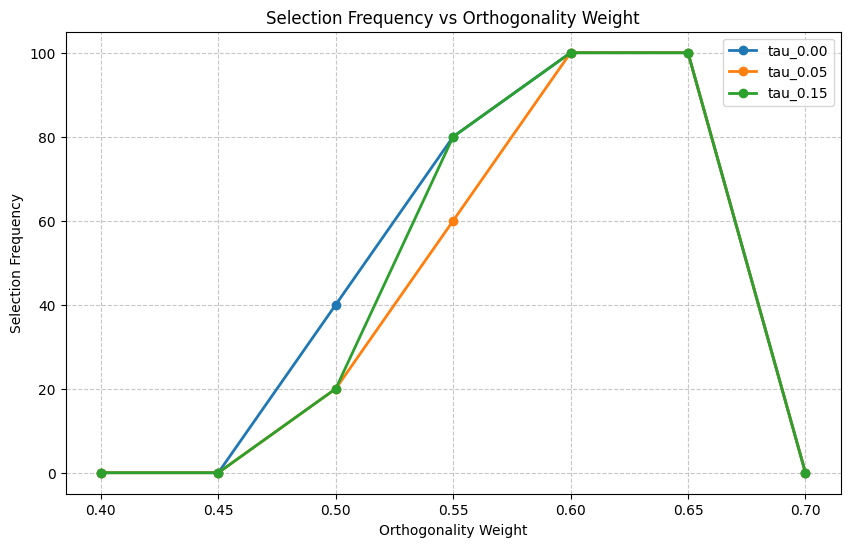

In [ ]:
df = pd.read_stata("/content/temp_yougov.dta")
weights = np.arange(0.40, 0.75, 0.05)
taus = [0.00, 0.05, 0.15]
num_iterations = 5
target_correlation = 0.90
target = 'christian_nationalism'
predictors = [
                   'presvote20post',
                   'housevote20post',
                   'senvote20post',
                   'pff_jb',
                   'pff_dt',
                   'pid7',
                   'election_fairnness',
                   'educ',
                   'hispanic',
                   'partisan_violence',
                   'immigrant_citizenship',
                   'immigrant_deport',
                   'auth_grid_1',
                   'auth_grid_3',
                   'auth_grid_2',
                   'faminc_new']

run_and_visualize_monte_carlo2(df, weights, num_iterations, target, target_correlation, predictors, taus)

## Stage 3: Testing the Elastic Net Implementation With Different Lambda Values

In [ ]:
from proxy_finder_elasticnet_orthogonalization import proxy_finder_elasticnet as pf_elasticnet
from itertools import product
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Debug statement: Neural Net test MSE = 0.015091979486534858
Proxy 1 for christian_nationalism: hispanic with score: -0.04095691799272644
Proxy 2 for christian_nationalism: turnout20post with score: -0.051654872747420165
Proxy 3 for christian_nationalism: index with score: -0.07263134738938155
Proxy 4 for christian_nationalism: partisan_violence with score: -0.11039048863906588
Proxy 5 for christian_nationalism: faminc_new with score: -0.12052104209802791
Proxy 6 for christian_nationalism: white with score: -0.1367539275110811
Proxy 7 for christian_nationalism: educ with score: -0.15683572105295168
Proxy 8 for christian_nationalism: auth_grid_2 with score: -0.17198121240853795
Proxy 9 for christian_nationalism: auth_grid_1 with score: -0.20087090338405791
Proxy 10 for christian_nationalism: auth_grid_3 with score: -0.20613049545065126
Proxy 11 for christian_nationalism: christian_nationalism with score: -0.

In [ ]:
def run_and_visualize_monte_carlo3(df, weight, num_iterations, target, target_correlation, predictors, pairs):
    proxy_name = (f'proxy_{target_correlation:.2f}')

    # Prepare dataset
    df_train, df_test = prepare_dataset(df, target, target_correlation)
    selection_tracker = {pair: 0 for pair in pairs}

    # Run iterations for each pair of lambdas
    for pair in pairs:
      print(f"Testing with lambda pair: {pair}")

      for i in range(num_iterations):
        print(f"Running iteration {i+1}/{num_iterations}")
        top_proxies = pf_elasticnet(df_train=df_train,
                                         df_test=df_test,
                                         target=target,
                                         predictors=predictors,
                                         num_proxies=10,
                                         orth_weight=weight,
                                         orthogonal_vars=predictors,
                                         lambda1=pair[0],
                                         lambda2=pair[1])

          # Update selection tracker for top pick
        if top_proxies[0] == proxy_name:
            selection_tracker[pair] += 1

    selection_frequencies = {pair: (count / num_iterations) * 100 for pair, count in selection_tracker.items()}

    # Create a grid of lambda values
    sorted_lambdas = sorted(pairs)
    n_lambdas = len(sorted_lambdas)
    heatmap_data = np.zeros((n_lambdas, n_lambdas))

    # Fill the heatmap data matrix
    for i, lambda1 in enumerate(sorted_lambdas):
        for j, lambda2 in enumerate(sorted_lambdas):
            heatmap_data[i, j] = selection_frequencies.get((lambda1, lambda2), 0)

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data,
                xticklabels=sorted_lambdas,
                yticklabels=sorted_lambdas,
                vmin=0,
                vmax=100,
                cmap='YlOrRd',
                annot=True,
                fmt='.1f',
                cbar_kws={'label': 'Selection Frequency (%)'},
                square=True)

    plt.xlabel('Lambda 2')
    plt.ylabel('Lambda 1')
    plt.title(f'Selection Frequency vs Lambda Pairs\nProxy: {proxy_name}, Orthogonality Weight: {weight}')
    plt.tight_layout()
    plt.show()

Testing with lambda pair: (0.001, 0.2)
Running iteration 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01764365404962748
Proxy 1 for christian_nationalism: presvote20post with score: 0.13453467362501992
Proxy 2 for christian_nationalism: pff_dt with score: 0.13423078145525436
Proxy 3 for christian_nationalism: senvote20post with score: 0.13233325869753668
Proxy 4 for christian_nationalism: housevote20post with score: 0.13005267183765207
Proxy 5 for christian_nationalism: proxy_0.90 with score: 0.1252381316813019
Proxy 6 for christian_nationalism: ideo7 with score: 0.12052370783411845
Proxy 7 for christian_nationalism: pid7 with score: 0.1034296293256036
Proxy 8 for christian_nationalism: immigrant_deport with score: 0.10244690491316434
Proxy 9 for christian_nationalism: election_fairnness with score: 0.0974112884096544
Proxy 10 for christian_nationalism: immigrant_citizenship with score: 0.075916817850527
Running iteration 2/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017411620081125997
Proxy 1 for christian_nationalism: pff_dt with score: 0.15471334643132884
Proxy 2 for christian_nationalism: presvote20post with score: 0.1295023820357295
Proxy 3 for christian_nationalism: proxy_0.90 with score: 0.12918585522445716
Proxy 4 for christian_nationalism: housevote20post with score: 0.12683977203801083
Proxy 5 for christian_nationalism: senvote20post with score: 0.12552535833307418
Proxy 6 for christian_nationalism: ideo7 with score: 0.12153639828360849
Proxy 7 for christian_nationalism: immigrant_deport with score: 0.11925417281309299
Proxy 8 for christian_nationalism: election_fairnness with score: 0.11358659287289913
Proxy 9 for christian_nationalism: pid7 with score: 0.08436861159464476
Proxy 10 for christian_nationalism: immigrant_citizenship with score: 0.0747113781693819
Running iteration 3/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.018733983177450016
Proxy 1 for christian_nationalism: pff_dt with score: 0.14320336833748826
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.12863629355706133
Proxy 3 for christian_nationalism: presvote20post with score: 0.11898213161094284
Proxy 4 for christian_nationalism: immigrant_deport with score: 0.11794483878677624
Proxy 5 for christian_nationalism: senvote20post with score: 0.11470806414690624
Proxy 6 for christian_nationalism: housevote20post with score: 0.11397084792441747
Proxy 7 for christian_nationalism: ideo7 with score: 0.11394110853857403
Proxy 8 for christian_nationalism: election_fairnness with score: 0.10314207977586662
Proxy 9 for christian_nationalism: auth_grid_1 with score: 0.07957910782792593
Proxy 10 for christian_nationalism: pid7 with score: 0.0691296492709404
Running iteration 4/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01817779959683108
Proxy 1 for christian_nationalism: pff_dt with score: 0.16461243803598524
Proxy 2 for christian_nationalism: presvote20post with score: 0.13957257502725084
Proxy 3 for christian_nationalism: election_fairnness with score: 0.13061793813533243
Proxy 4 for christian_nationalism: senvote20post with score: 0.1294263109318531
Proxy 5 for christian_nationalism: proxy_0.90 with score: 0.128833422894259
Proxy 6 for christian_nationalism: housevote20post with score: 0.12725898606661357
Proxy 7 for christian_nationalism: ideo7 with score: 0.12148695562308998
Proxy 8 for christian_nationalism: immigrant_deport with score: 0.11108522211753787
Proxy 9 for christian_nationalism: pid7 with score: 0.08605098649760579
Proxy 10 for christian_nationalism: immigrant_citizenship with score: 0.08039921650606842
Running iteration 5/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017960787885037424
Proxy 1 for christian_nationalism: pff_dt with score: 0.14242872397013567
Proxy 2 for christian_nationalism: presvote20post with score: 0.13859315263271843
Proxy 3 for christian_nationalism: senvote20post with score: 0.13411833144023858
Proxy 4 for christian_nationalism: housevote20post with score: 0.1335078993314947
Proxy 5 for christian_nationalism: proxy_0.90 with score: 0.12633522869956912
Proxy 6 for christian_nationalism: election_fairnness with score: 0.12390408888738721
Proxy 7 for christian_nationalism: ideo7 with score: 0.11911260932423057
Proxy 8 for christian_nationalism: immigrant_deport with score: 0.11478161281784922
Proxy 9 for christian_nationalism: pid7 with score: 0.09988529969430765
Proxy 10 for christian_nationalism: auth_grid_1 with score: 0.07651683381893831
Running iteration 6/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01720265082040147
Proxy 1 for christian_nationalism: pff_dt with score: 0.1589079057258576
Proxy 2 for christian_nationalism: presvote20post with score: 0.1375882826746006
Proxy 3 for christian_nationalism: senvote20post with score: 0.13368506997434534
Proxy 4 for christian_nationalism: housevote20post with score: 0.1326152427053306
Proxy 5 for christian_nationalism: proxy_0.90 with score: 0.13050388734344273
Proxy 6 for christian_nationalism: ideo7 with score: 0.12565815568501662
Proxy 7 for christian_nationalism: immigrant_deport with score: 0.11535248100128549
Proxy 8 for christian_nationalism: election_fairnness with score: 0.10468647509423945
Proxy 9 for christian_nationalism: pid7 with score: 0.09279165465968112
Proxy 10 for christian_nationalism: immigrant_citizenship with score: 0.0895568532554973
Running iteration 7/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Debug statement: Neural Net test MSE = 0.017528332760120665
Proxy 1 for christian_nationalism: pff_dt with score: 0.13691708096974736
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.13059815714119993
Proxy 3 for christian_nationalism: ideo7 with score: 0.11972216751574064
Proxy 4 for christian_nationalism: immigrant_deport with score: 0.11960680012617066
Proxy 5 for christian_nationalism: presvote20post with score: 0.11909562352466885
Proxy 6 for christian_nationalism: senvote20post with score: 0.11316205178826369
Proxy 7 for christian_nationalism: housevote20post with score: 0.1128317599334211
Proxy 8 for christian_nationalism: election_fairnness with score: 0.11079577170982233
Proxy 9 for christian_nationalism: auth_grid_1 with score: 0.08048393008167773
Proxy 10 for christian_nationalism: immigrant_citizenship with score: 0.07829048414754781
Testing with lambda pair: (0.001, 0.3)
Running itera

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017736707911430855
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.0252215949104152
Proxy 2 for christian_nationalism: ideo7 with score: -0.002411421524607771
Proxy 3 for christian_nationalism: pff_dt with score: -0.0033465415963167544
Proxy 4 for christian_nationalism: auth_grid_1 with score: -0.0052756721696749775
Proxy 5 for christian_nationalism: index with score: -0.00537226058620446
Proxy 6 for christian_nationalism: turnout20post with score: -0.00578984351250268
Proxy 7 for christian_nationalism: immigrant_deport with score: -0.007801696792978291
Proxy 8 for christian_nationalism: auth_grid_3 with score: -0.015597503118187167
Proxy 9 for christian_nationalism: auth_grid_2 with score: -0.019976389164225866
Proxy 10 for christian_nationalism: educ with score: -0.020951084972484935
Running iteration 2/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01795403207303711
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.02803780561979391
Proxy 2 for christian_nationalism: auth_grid_3 with score: 0.005630661999444911
Proxy 3 for christian_nationalism: auth_grid_1 with score: 0.00015065443337959616
Proxy 4 for christian_nationalism: immigrant_deport with score: -0.002211585942734018
Proxy 5 for christian_nationalism: index with score: -0.004340628220604261
Proxy 6 for christian_nationalism: turnout20post with score: -0.006665593786019643
Proxy 7 for christian_nationalism: ideo7 with score: -0.007912076350087976
Proxy 8 for christian_nationalism: pff_dt with score: -0.014810191658547633
Proxy 9 for christian_nationalism: auth_grid_2 with score: -0.02223979085302004
Proxy 10 for christian_nationalism: educ with score: -0.028215802464510664
Running iteration 3/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017145502145137534
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.026585715138547517
Proxy 2 for christian_nationalism: auth_grid_1 with score: 0.0025623881053729175
Proxy 3 for christian_nationalism: auth_grid_3 with score: -0.0020851966251829723
Proxy 4 for christian_nationalism: turnout20post with score: -0.00359468798264614
Proxy 5 for christian_nationalism: ideo7 with score: -0.004471806186821831
Proxy 6 for christian_nationalism: index with score: -0.005798846486536259
Proxy 7 for christian_nationalism: immigrant_deport with score: -0.009888604961887953
Proxy 8 for christian_nationalism: pff_dt with score: -0.015827132999003846
Proxy 9 for christian_nationalism: auth_grid_2 with score: -0.02102101912445002
Proxy 10 for christian_nationalism: educ with score: -0.023369025599820223
Running iteration 4/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017370185504245014
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.02658200030044841
Proxy 2 for christian_nationalism: turnout20post with score: -0.0034811983945931225
Proxy 3 for christian_nationalism: ideo7 with score: -0.004150859407119817
Proxy 4 for christian_nationalism: index with score: -0.005562341261158156
Proxy 5 for christian_nationalism: auth_grid_1 with score: -0.005809662156568848
Proxy 6 for christian_nationalism: auth_grid_3 with score: -0.007730425136128594
Proxy 7 for christian_nationalism: immigrant_deport with score: -0.008274909119218854
Proxy 8 for christian_nationalism: auth_grid_2 with score: -0.016089106527529567
Proxy 9 for christian_nationalism: pff_dt with score: -0.022761046213425395
Proxy 10 for christian_nationalism: immigrant_citizenship with score: -0.02342083771472553
Running iteration 5/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.018503156553450615
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.03000046435709372
Proxy 2 for christian_nationalism: auth_grid_1 with score: 0.013920772459615732
Proxy 3 for christian_nationalism: auth_grid_3 with score: 0.007776084610119208
Proxy 4 for christian_nationalism: immigrant_deport with score: -0.002971344840910134
Proxy 5 for christian_nationalism: index with score: -0.005498888043811824
Proxy 6 for christian_nationalism: turnout20post with score: -0.0058902044787311324
Proxy 7 for christian_nationalism: ideo7 with score: -0.008359615560684097
Proxy 8 for christian_nationalism: auth_grid_2 with score: -0.014720365899281426
Proxy 9 for christian_nationalism: pff_dt with score: -0.022312659021473058
Proxy 10 for christian_nationalism: immigrant_citizenship with score: -0.02603499109884616
Running iteration 6/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017406840099552158
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.030156782810554505
Proxy 2 for christian_nationalism: auth_grid_1 with score: 0.005061783708105921
Proxy 3 for christian_nationalism: auth_grid_3 with score: -0.004884482336457441
Proxy 4 for christian_nationalism: turnout20post with score: -0.005101279986525666
Proxy 5 for christian_nationalism: index with score: -0.006050101608310101
Proxy 6 for christian_nationalism: ideo7 with score: -0.009175934660885843
Proxy 7 for christian_nationalism: pff_dt with score: -0.012971519707479784
Proxy 8 for christian_nationalism: auth_grid_2 with score: -0.015439613802078964
Proxy 9 for christian_nationalism: immigrant_deport with score: -0.016889352731857904
Proxy 10 for christian_nationalism: educ with score: -0.02046543614840622
Running iteration 7/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Debug statement: Neural Net test MSE = 0.017207733046245167
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.03212273308667635
Proxy 2 for christian_nationalism: auth_grid_1 with score: 0.007588885069285151
Proxy 3 for christian_nationalism: auth_grid_3 with score: -0.0005612265565921593
Proxy 4 for christian_nationalism: immigrant_deport with score: -0.00228603850182324
Proxy 5 for christian_nationalism: ideo7 with score: -0.005140855497171637
Proxy 6 for christian_nationalism: turnout20post with score: -0.005774100880349166
Proxy 7 for christian_nationalism: index with score: -0.005922918257629252
Proxy 8 for christian_nationalism: pff_dt with score: -0.012587178133741272
Proxy 9 for christian_nationalism: auth_grid_2 with score: -0.016781157912638095
Proxy 10 for christian_nationalism: immigrant_citizenship with score: -0.022647955168845463
Testing with lambda pair: (0.001, 0.4)
Running iterati

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01844650884475857
Proxy 1 for christian_nationalism: index with score: -0.00988566035300881
Proxy 2 for christian_nationalism: turnout20post with score: -0.013077295841040129
Proxy 3 for christian_nationalism: white with score: -0.05458569733047245
Proxy 4 for christian_nationalism: auth_grid_1 with score: -0.07748928606737407
Proxy 5 for christian_nationalism: auth_grid_2 with score: -0.08004244576890619
Proxy 6 for christian_nationalism: educ with score: -0.09359766140108247
Proxy 7 for christian_nationalism: faminc_new with score: -0.09691208396569866
Proxy 8 for christian_nationalism: auth_grid_3 with score: -0.09810218730772523
Proxy 9 for christian_nationalism: partisan_violence with score: -0.10043095788165197
Proxy 10 for christian_nationalism: hispanic with score: -0.10205188709328228
Running iteration 2/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01793877164701243
Proxy 1 for christian_nationalism: index with score: -0.010493574484725423
Proxy 2 for christian_nationalism: turnout20post with score: -0.01161098390529284
Proxy 3 for christian_nationalism: white with score: -0.055494696469953995
Proxy 4 for christian_nationalism: educ with score: -0.08049543788867235
Proxy 5 for christian_nationalism: auth_grid_2 with score: -0.0848379885243115
Proxy 6 for christian_nationalism: auth_grid_1 with score: -0.09276536488409848
Proxy 7 for christian_nationalism: faminc_new with score: -0.09676818394680382
Proxy 8 for christian_nationalism: partisan_violence with score: -0.09984854024755219
Proxy 9 for christian_nationalism: auth_grid_3 with score: -0.10033119185002634
Proxy 10 for christian_nationalism: hispanic with score: -0.10174682228454372
Running iteration 3/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01766591207808476
Proxy 1 for christian_nationalism: index with score: -0.010616285753919232
Proxy 2 for christian_nationalism: turnout20post with score: -0.012378654935060955
Proxy 3 for christian_nationalism: white with score: -0.05599937724283248
Proxy 4 for christian_nationalism: auth_grid_2 with score: -0.06824503651642756
Proxy 5 for christian_nationalism: educ with score: -0.07815926776774351
Proxy 6 for christian_nationalism: auth_grid_1 with score: -0.08368737969142277
Proxy 7 for christian_nationalism: auth_grid_3 with score: -0.09077066432740842
Proxy 8 for christian_nationalism: faminc_new with score: -0.09614287255818048
Proxy 9 for christian_nationalism: partisan_violence with score: -0.10037481296896421
Proxy 10 for christian_nationalism: hispanic with score: -0.1017103909514474
Running iteration 4/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017928484179229404
Proxy 1 for christian_nationalism: index with score: -0.009776586953375369
Proxy 2 for christian_nationalism: turnout20post with score: -0.013461047296497344
Proxy 3 for christian_nationalism: white with score: -0.052600748744642226
Proxy 4 for christian_nationalism: auth_grid_1 with score: -0.08287792304818731
Proxy 5 for christian_nationalism: educ with score: -0.08854075155195285
Proxy 6 for christian_nationalism: auth_grid_2 with score: -0.0933328519774532
Proxy 7 for christian_nationalism: auth_grid_3 with score: -0.09428152750884931
Proxy 8 for christian_nationalism: faminc_new with score: -0.09807636032603775
Proxy 9 for christian_nationalism: hispanic with score: -0.10160331165747208
Proxy 10 for christian_nationalism: partisan_violence with score: -0.10163488168649537
Running iteration 5/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01859324298624074
Proxy 1 for christian_nationalism: index with score: -0.010461887457993804
Proxy 2 for christian_nationalism: turnout20post with score: -0.012138597185466586
Proxy 3 for christian_nationalism: white with score: -0.054077124048898154
Proxy 4 for christian_nationalism: auth_grid_1 with score: -0.07652934623791596
Proxy 5 for christian_nationalism: auth_grid_2 with score: -0.0812072009082304
Proxy 6 for christian_nationalism: educ with score: -0.08220999327297485
Proxy 7 for christian_nationalism: auth_grid_3 with score: -0.08907628630946646
Proxy 8 for christian_nationalism: faminc_new with score: -0.09763273978497555
Proxy 9 for christian_nationalism: partisan_violence with score: -0.09898280017801904
Proxy 10 for christian_nationalism: hispanic with score: -0.10206292429646098
Running iteration 6/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017841681117526726
Proxy 1 for christian_nationalism: index with score: -0.010812303471569732
Proxy 2 for christian_nationalism: turnout20post with score: -0.01180665722481368
Proxy 3 for christian_nationalism: white with score: -0.05472294753648051
Proxy 4 for christian_nationalism: auth_grid_2 with score: -0.07746728214777684
Proxy 5 for christian_nationalism: educ with score: -0.08152269960472333
Proxy 6 for christian_nationalism: auth_grid_1 with score: -0.09180001621824144
Proxy 7 for christian_nationalism: faminc_new with score: -0.09703325466071042
Proxy 8 for christian_nationalism: partisan_violence with score: -0.1005976840630361
Proxy 9 for christian_nationalism: auth_grid_3 with score: -0.1016482958120056
Proxy 10 for christian_nationalism: hispanic with score: -0.10202892935876999
Running iteration 7/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.018056960570778227
Proxy 1 for christian_nationalism: index with score: -0.01042211019308085
Proxy 2 for christian_nationalism: turnout20post with score: -0.013240471284758928
Proxy 3 for christian_nationalism: white with score: -0.05574428890386054
Proxy 4 for christian_nationalism: auth_grid_2 with score: -0.08222816095428818
Proxy 5 for christian_nationalism: auth_grid_1 with score: -0.08863050057883433
Proxy 6 for christian_nationalism: educ with score: -0.09000152326207622
Proxy 7 for christian_nationalism: auth_grid_3 with score: -0.09726081087823249
Proxy 8 for christian_nationalism: faminc_new with score: -0.09798467876868597
Proxy 9 for christian_nationalism: partisan_violence with score: -0.09987940480336835
Proxy 10 for christian_nationalism: hispanic with score: -0.10151884952832405
Testing with lambda pair: (0.001, 0.5)
Running iteration 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.018807544826393484
Proxy 1 for christian_nationalism: index with score: -0.01645444666739176
Proxy 2 for christian_nationalism: turnout20post with score: -0.02026008166280798
Proxy 3 for christian_nationalism: white with score: -0.08843918716521917
Proxy 4 for christian_nationalism: faminc_new with score: -0.15302380474773844
Proxy 5 for christian_nationalism: hispanic with score: -0.15860442385238815
Proxy 6 for christian_nationalism: partisan_violence with score: -0.1599591766235145
Proxy 7 for christian_nationalism: auth_grid_2 with score: -0.16152518766577417
Proxy 8 for christian_nationalism: educ with score: -0.16177552663025552
Proxy 9 for christian_nationalism: auth_grid_1 with score: -0.197965765880713
Proxy 10 for christian_nationalism: auth_grid_3 with score: -0.21110397663521713
Running iteration 2/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.016819159448103086
Proxy 1 for christian_nationalism: index with score: -0.0162644876215143
Proxy 2 for christian_nationalism: turnout20post with score: -0.020355601452066593
Proxy 3 for christian_nationalism: white with score: -0.08815159901953812
Proxy 4 for christian_nationalism: faminc_new with score: -0.15155703416985392
Proxy 5 for christian_nationalism: auth_grid_2 with score: -0.1524090605409563
Proxy 6 for christian_nationalism: hispanic with score: -0.1587847265531025
Proxy 7 for christian_nationalism: partisan_violence with score: -0.16016272995160225
Proxy 8 for christian_nationalism: educ with score: -0.16900604677947906
Proxy 9 for christian_nationalism: auth_grid_3 with score: -0.18928551276576144
Proxy 10 for christian_nationalism: auth_grid_1 with score: -0.20352866503481215
Running iteration 3/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01708351489818257
Proxy 1 for christian_nationalism: index with score: -0.016978006876592754
Proxy 2 for christian_nationalism: turnout20post with score: -0.02080014391643626
Proxy 3 for christian_nationalism: white with score: -0.08876817412146427
Proxy 4 for christian_nationalism: faminc_new with score: -0.15185778930157162
Proxy 5 for christian_nationalism: hispanic with score: -0.1587232888656553
Proxy 6 for christian_nationalism: auth_grid_2 with score: -0.1590580447902533
Proxy 7 for christian_nationalism: partisan_violence with score: -0.15927600654927382
Proxy 8 for christian_nationalism: educ with score: -0.1696942489311719
Proxy 9 for christian_nationalism: auth_grid_3 with score: -0.18990122853981792
Proxy 10 for christian_nationalism: auth_grid_1 with score: -0.19904147737219652
Running iteration 4/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01804962409807051
Proxy 1 for christian_nationalism: index with score: -0.01576218718078045
Proxy 2 for christian_nationalism: turnout20post with score: -0.022119105708474605
Proxy 3 for christian_nationalism: white with score: -0.08709769930737897
Proxy 4 for christian_nationalism: faminc_new with score: -0.15267035763470155
Proxy 5 for christian_nationalism: partisan_violence with score: -0.15854551222551178
Proxy 6 for christian_nationalism: hispanic with score: -0.15877897692011322
Proxy 7 for christian_nationalism: educ with score: -0.1640388954477211
Proxy 8 for christian_nationalism: auth_grid_2 with score: -0.17381698270500084
Proxy 9 for christian_nationalism: auth_grid_1 with score: -0.21048738842317177
Proxy 10 for christian_nationalism: auth_grid_3 with score: -0.21430413082788802
Running iteration 5/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Debug statement: Neural Net test MSE = 0.018168399573364493
Proxy 1 for christian_nationalism: index with score: -0.016459343820547954
Proxy 2 for christian_nationalism: turnout20post with score: -0.019776945366890307
Proxy 3 for christian_nationalism: white with score: -0.08773960379598905
Proxy 4 for christian_nationalism: faminc_new with score: -0.15363298184736926
Proxy 5 for christian_nationalism: auth_grid_2 with score: -0.15750688896415682
Proxy 6 for christian_nationalism: hispanic with score: -0.15890601301219717
Proxy 7 for christian_nationalism: partisan_violence with score: -0.1609580911642475
Proxy 8 for christian_nationalism: educ with score: -0.16143952858823918
Proxy 9 for christian_nationalism: auth_grid_1 with score: -0.19827285260170582
Proxy 10 for christian_nationalism: auth_grid_3 with score: -0.20771672609633382
Running iteration 6/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01759285541132881
Proxy 1 for christian_nationalism: index with score: -0.015993983912950024
Proxy 2 for christian_nationalism: turnout20post with score: -0.020885296448888643
Proxy 3 for christian_nationalism: white with score: -0.08757545835892669
Proxy 4 for christian_nationalism: faminc_new with score: -0.1520639801013815
Proxy 5 for christian_nationalism: hispanic with score: -0.15896084322752968
Proxy 6 for christian_nationalism: partisan_violence with score: -0.1604364005675199
Proxy 7 for christian_nationalism: auth_grid_2 with score: -0.1635136386173387
Proxy 8 for christian_nationalism: educ with score: -0.1681692469018483
Proxy 9 for christian_nationalism: auth_grid_3 with score: -0.2003908737309282
Proxy 10 for christian_nationalism: auth_grid_1 with score: -0.20249231738182344
Running iteration 7/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.018029886294372455
Proxy 1 for christian_nationalism: index with score: -0.01581469098138225
Proxy 2 for christian_nationalism: turnout20post with score: -0.020401204657403013
Proxy 3 for christian_nationalism: white with score: -0.08754636775799152
Proxy 4 for christian_nationalism: faminc_new with score: -0.1520220758285414
Proxy 5 for christian_nationalism: hispanic with score: -0.15890251465299274
Proxy 6 for christian_nationalism: partisan_violence with score: -0.1619023621373133
Proxy 7 for christian_nationalism: educ with score: -0.16562349297002604
Proxy 8 for christian_nationalism: auth_grid_2 with score: -0.1759987641754284
Proxy 9 for christian_nationalism: auth_grid_3 with score: -0.19101101592522257
Proxy 10 for christian_nationalism: auth_grid_1 with score: -0.20397847555474025
Testing with lambda pair: (0.005, 0.2)
Running iteration 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01742975025134766
Proxy 1 for christian_nationalism: pff_dt with score: 0.14388347128724208
Proxy 2 for christian_nationalism: presvote20post with score: 0.12552761183637415
Proxy 3 for christian_nationalism: senvote20post with score: 0.11460157024253692
Proxy 4 for christian_nationalism: proxy_0.90 with score: 0.11308559489089323
Proxy 5 for christian_nationalism: housevote20post with score: 0.11244719600789799
Proxy 6 for christian_nationalism: ideo7 with score: 0.1076978931788624
Proxy 7 for christian_nationalism: election_fairnness with score: 0.10719966718268689
Proxy 8 for christian_nationalism: immigrant_deport with score: 0.09208332956532325
Proxy 9 for christian_nationalism: pid7 with score: 0.08420361506527263
Proxy 10 for christian_nationalism: immigrant_citizenship with score: 0.06282381438069015
Running iteration 2/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01743709527111386
Proxy 1 for christian_nationalism: pff_dt with score: 0.12343758678450975
Proxy 2 for christian_nationalism: senvote20post with score: 0.11408104007741038
Proxy 3 for christian_nationalism: housevote20post with score: 0.11334436852818858
Proxy 4 for christian_nationalism: presvote20post with score: 0.11243037199403441
Proxy 5 for christian_nationalism: proxy_0.90 with score: 0.11174672232973584
Proxy 6 for christian_nationalism: ideo7 with score: 0.10366375409036234
Proxy 7 for christian_nationalism: immigrant_deport with score: 0.10003886596180953
Proxy 8 for christian_nationalism: election_fairnness with score: 0.08987357683086755
Proxy 9 for christian_nationalism: pid7 with score: 0.07408977182702989
Proxy 10 for christian_nationalism: auth_grid_1 with score: 0.06324306585636333
Running iteration 3/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.019018947159802835
Proxy 1 for christian_nationalism: pff_dt with score: 0.14456819862991913
Proxy 2 for christian_nationalism: presvote20post with score: 0.11969632779337905
Proxy 3 for christian_nationalism: senvote20post with score: 0.11514095177815653
Proxy 4 for christian_nationalism: housevote20post with score: 0.1122205478182034
Proxy 5 for christian_nationalism: proxy_0.90 with score: 0.11094564496271
Proxy 6 for christian_nationalism: ideo7 with score: 0.10524322142176644
Proxy 7 for christian_nationalism: immigrant_deport with score: 0.09742488985502021
Proxy 8 for christian_nationalism: election_fairnness with score: 0.09147698163682136
Proxy 9 for christian_nationalism: pid7 with score: 0.08096108951667744
Proxy 10 for christian_nationalism: auth_grid_1 with score: 0.06429788000010164
Running iteration 4/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017590248032713685
Proxy 1 for christian_nationalism: pff_dt with score: 0.13406490657368322
Proxy 2 for christian_nationalism: presvote20post with score: 0.1189083383881385
Proxy 3 for christian_nationalism: proxy_0.90 with score: 0.11471235731986096
Proxy 4 for christian_nationalism: immigrant_deport with score: 0.11204220110027482
Proxy 5 for christian_nationalism: senvote20post with score: 0.11030023326820859
Proxy 6 for christian_nationalism: housevote20post with score: 0.10706734087802972
Proxy 7 for christian_nationalism: ideo7 with score: 0.10702408132529444
Proxy 8 for christian_nationalism: election_fairnness with score: 0.09111523889092749
Proxy 9 for christian_nationalism: pid7 with score: 0.07033451654013692
Proxy 10 for christian_nationalism: immigrant_citizenship with score: 0.06591907368092786
Running iteration 5/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01778718980513703
Proxy 1 for christian_nationalism: pff_dt with score: 0.12862664185014802
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.11634692856778117
Proxy 3 for christian_nationalism: presvote20post with score: 0.1087555102150998
Proxy 4 for christian_nationalism: immigrant_deport with score: 0.10732738486099938
Proxy 5 for christian_nationalism: housevote20post with score: 0.10526060003453586
Proxy 6 for christian_nationalism: senvote20post with score: 0.10518894664893541
Proxy 7 for christian_nationalism: ideo7 with score: 0.10365516580023475
Proxy 8 for christian_nationalism: election_fairnness with score: 0.0878110331674272
Proxy 9 for christian_nationalism: auth_grid_1 with score: 0.07151750031272092
Proxy 10 for christian_nationalism: immigrant_citizenship with score: 0.07055822234219633
Running iteration 6/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01730119194359063
Proxy 1 for christian_nationalism: pff_dt with score: 0.13113340970656676
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.11546100835739384
Proxy 3 for christian_nationalism: presvote20post with score: 0.10396369731223462
Proxy 4 for christian_nationalism: housevote20post with score: 0.09973170936198417
Proxy 5 for christian_nationalism: senvote20post with score: 0.09845407651049265
Proxy 6 for christian_nationalism: ideo7 with score: 0.09819895619879475
Proxy 7 for christian_nationalism: immigrant_deport with score: 0.09551207083628382
Proxy 8 for christian_nationalism: election_fairnness with score: 0.08177252317418993
Proxy 9 for christian_nationalism: auth_grid_1 with score: 0.06060185007632535
Proxy 10 for christian_nationalism: immigrant_citizenship with score: 0.058451559628465405
Running iteration 7/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.018295006680214207
Proxy 1 for christian_nationalism: pff_dt with score: 0.12429701803490914
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.1169743829754529
Proxy 3 for christian_nationalism: presvote20post with score: 0.1075750124176301
Proxy 4 for christian_nationalism: ideo7 with score: 0.10209164472926728
Proxy 5 for christian_nationalism: senvote20post with score: 0.09910788126451414
Proxy 6 for christian_nationalism: housevote20post with score: 0.09832418747057792
Proxy 7 for christian_nationalism: immigrant_deport with score: 0.09779674940158153
Proxy 8 for christian_nationalism: election_fairnness with score: 0.09738346266634265
Proxy 9 for christian_nationalism: auth_grid_1 with score: 0.06612031764668569
Proxy 10 for christian_nationalism: pid7 with score: 0.06395816234775833
Testing with lambda pair: (0.005, 0.3)
Running iteration 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01819782787269349
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.008798090625935423
Proxy 2 for christian_nationalism: auth_grid_1 with score: -0.005474677927159666
Proxy 3 for christian_nationalism: turnout20post with score: -0.007615706723412593
Proxy 4 for christian_nationalism: index with score: -0.00832937767832404
Proxy 5 for christian_nationalism: auth_grid_2 with score: -0.011120220094047159
Proxy 6 for christian_nationalism: auth_grid_3 with score: -0.01636781307086639
Proxy 7 for christian_nationalism: pff_dt with score: -0.02724748762291862
Proxy 8 for christian_nationalism: ideo7 with score: -0.031113119935523625
Proxy 9 for christian_nationalism: educ with score: -0.03427479385336534
Proxy 10 for christian_nationalism: immigrant_deport with score: -0.03574765163799881
Running iteration 2/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.0181997230427294
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.012650593152610773
Proxy 2 for christian_nationalism: auth_grid_1 with score: -0.005474617954049771
Proxy 3 for christian_nationalism: turnout20post with score: -0.007327660618290762
Proxy 4 for christian_nationalism: index with score: -0.008891317735265874
Proxy 5 for christian_nationalism: auth_grid_3 with score: -0.015715014395811633
Proxy 6 for christian_nationalism: auth_grid_2 with score: -0.017291580951276878
Proxy 7 for christian_nationalism: immigrant_deport with score: -0.023901934162738003
Proxy 8 for christian_nationalism: ideo7 with score: -0.02828067495354869
Proxy 9 for christian_nationalism: educ with score: -0.033754293131739194
Proxy 10 for christian_nationalism: white with score: -0.03750547682751669
Running iteration 3/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017507580081698153
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.011767985293035965
Proxy 2 for christian_nationalism: auth_grid_1 with score: -0.0013342331915284222
Proxy 3 for christian_nationalism: auth_grid_3 with score: -0.004872591057305045
Proxy 4 for christian_nationalism: turnout20post with score: -0.007154958186682666
Proxy 5 for christian_nationalism: index with score: -0.008666452995531475
Proxy 6 for christian_nationalism: auth_grid_2 with score: -0.018135801073768776
Proxy 7 for christian_nationalism: ideo7 with score: -0.025626803311316948
Proxy 8 for christian_nationalism: immigrant_deport with score: -0.02645045544288735
Proxy 9 for christian_nationalism: educ with score: -0.03027602460027741
Proxy 10 for christian_nationalism: white with score: -0.036880788131816535
Running iteration 4/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01772941279285577
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.013550755647309204
Proxy 2 for christian_nationalism: auth_grid_1 with score: 0.005524916131077279
Proxy 3 for christian_nationalism: auth_grid_3 with score: -0.006688242151598134
Proxy 4 for christian_nationalism: index with score: -0.008448210887604118
Proxy 5 for christian_nationalism: turnout20post with score: -0.00919255312855641
Proxy 6 for christian_nationalism: ideo7 with score: -0.020904895791586164
Proxy 7 for christian_nationalism: auth_grid_2 with score: -0.021580934121937012
Proxy 8 for christian_nationalism: immigrant_deport with score: -0.021659042617805685
Proxy 9 for christian_nationalism: white with score: -0.036337936666434735
Proxy 10 for christian_nationalism: educ with score: -0.036651322827528324
Running iteration 5/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.018441063228548556
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.011432300202650375
Proxy 2 for christian_nationalism: auth_grid_1 with score: -0.0029679302437737587
Proxy 3 for christian_nationalism: turnout20post with score: -0.0075936323647194685
Proxy 4 for christian_nationalism: index with score: -0.008802407158402008
Proxy 5 for christian_nationalism: auth_grid_3 with score: -0.016526893806700832
Proxy 6 for christian_nationalism: ideo7 with score: -0.01918900745582966
Proxy 7 for christian_nationalism: pff_dt with score: -0.02240737727702491
Proxy 8 for christian_nationalism: auth_grid_2 with score: -0.023080101252078294
Proxy 9 for christian_nationalism: educ with score: -0.03314409320060683
Proxy 10 for christian_nationalism: white with score: -0.035166780909570275
Running iteration 6/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.018618677251986453
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.008116550064870304
Proxy 2 for christian_nationalism: auth_grid_1 with score: 0.000880645906421812
Proxy 3 for christian_nationalism: auth_grid_3 with score: -0.0024664019323593495
Proxy 4 for christian_nationalism: auth_grid_2 with score: -0.006280791063058566
Proxy 5 for christian_nationalism: index with score: -0.008073190013129599
Proxy 6 for christian_nationalism: turnout20post with score: -0.008327506650824676
Proxy 7 for christian_nationalism: immigrant_deport with score: -0.023717536583420212
Proxy 8 for christian_nationalism: ideo7 with score: -0.02636892670652488
Proxy 9 for christian_nationalism: white with score: -0.03562914379976191
Proxy 10 for christian_nationalism: educ with score: -0.037344984272230854
Running iteration 7/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.018293033701741724
Proxy 1 for christian_nationalism: proxy_0.90 with score: 0.012222908138167954
Proxy 2 for christian_nationalism: auth_grid_1 with score: -0.00741752156718882
Proxy 3 for christian_nationalism: turnout20post with score: -0.007478420715886832
Proxy 4 for christian_nationalism: index with score: -0.008662046238453118
Proxy 5 for christian_nationalism: auth_grid_3 with score: -0.01775161842953424
Proxy 6 for christian_nationalism: auth_grid_2 with score: -0.0231747044231857
Proxy 7 for christian_nationalism: ideo7 with score: -0.025102114879877457
Proxy 8 for christian_nationalism: immigrant_deport with score: -0.02672529606876578
Proxy 9 for christian_nationalism: pff_dt with score: -0.029196510263279685
Proxy 10 for christian_nationalism: educ with score: -0.03202495456696648
Testing with lambda pair: (0.005, 0.4)
Running iteration 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017708032226041028
Proxy 1 for christian_nationalism: turnout20post with score: -0.013217949302839455
Proxy 2 for christian_nationalism: index with score: -0.013332753318418038
Proxy 3 for christian_nationalism: white with score: -0.06233961227362485
Proxy 4 for christian_nationalism: auth_grid_3 with score: -0.09114816217432652
Proxy 5 for christian_nationalism: auth_grid_1 with score: -0.09175958667696818
Proxy 6 for christian_nationalism: auth_grid_2 with score: -0.09492241448915033
Proxy 7 for christian_nationalism: educ with score: -0.09588421193541358
Proxy 8 for christian_nationalism: faminc_new with score: -0.10123640356496956
Proxy 9 for christian_nationalism: hispanic with score: -0.10567349008642085
Proxy 10 for christian_nationalism: partisan_violence with score: -0.10583729400342787
Running iteration 2/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.0177871801157596
Proxy 1 for christian_nationalism: index with score: -0.013571345573034903
Proxy 2 for christian_nationalism: turnout20post with score: -0.014236661176591586
Proxy 3 for christian_nationalism: white with score: -0.061254454221558834
Proxy 4 for christian_nationalism: educ with score: -0.09329756755259894
Proxy 5 for christian_nationalism: auth_grid_2 with score: -0.09486691342094423
Proxy 6 for christian_nationalism: auth_grid_1 with score: -0.09768493656939198
Proxy 7 for christian_nationalism: faminc_new with score: -0.10014499603394206
Proxy 8 for christian_nationalism: partisan_violence with score: -0.10390338176775113
Proxy 9 for christian_nationalism: hispanic with score: -0.10622616911795618
Proxy 10 for christian_nationalism: auth_grid_3 with score: -0.10769510137032237
Running iteration 3/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017947823162065626
Proxy 1 for christian_nationalism: turnout20post with score: -0.012670168122862984
Proxy 2 for christian_nationalism: index with score: -0.01389064600098156
Proxy 3 for christian_nationalism: white with score: -0.06246191898479495
Proxy 4 for christian_nationalism: educ with score: -0.0853493218166849
Proxy 5 for christian_nationalism: auth_grid_2 with score: -0.09322473316204642
Proxy 6 for christian_nationalism: auth_grid_3 with score: -0.09635596313984209
Proxy 7 for christian_nationalism: auth_grid_1 with score: -0.09770821371518947
Proxy 8 for christian_nationalism: faminc_new with score: -0.10125694252001961
Proxy 9 for christian_nationalism: partisan_violence with score: -0.10399063653677078
Proxy 10 for christian_nationalism: hispanic with score: -0.10631387287709354
Running iteration 4/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Debug statement: Neural Net test MSE = 0.017294685010867533
Proxy 1 for christian_nationalism: index with score: -0.013193220145242317
Proxy 2 for christian_nationalism: turnout20post with score: -0.015019873130957267
Proxy 3 for christian_nationalism: white with score: -0.06187616537360349
Proxy 4 for christian_nationalism: educ with score: -0.09336247044390414
Proxy 5 for christian_nationalism: auth_grid_2 with score: -0.0958263871520257
Proxy 6 for christian_nationalism: auth_grid_3 with score: -0.09653050084414697
Proxy 7 for christian_nationalism: faminc_new with score: -0.10087163376150397
Proxy 8 for christian_nationalism: auth_grid_1 with score: -0.10176360189370103
Proxy 9 for christian_nationalism: partisan_violence with score: -0.10538927258867736
Proxy 10 for christian_nationalism: hispanic with score: -0.10628936219658994
Running iteration 5/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017990941750941666
Proxy 1 for christian_nationalism: index with score: -0.01301569409366659
Proxy 2 for christian_nationalism: turnout20post with score: -0.014382653660734074
Proxy 3 for christian_nationalism: white with score: -0.06094771473017474
Proxy 4 for christian_nationalism: auth_grid_1 with score: -0.09078137455162497
Proxy 5 for christian_nationalism: educ with score: -0.09350981590370006
Proxy 6 for christian_nationalism: auth_grid_2 with score: -0.09718288294334862
Proxy 7 for christian_nationalism: faminc_new with score: -0.10156277686231899
Proxy 8 for christian_nationalism: auth_grid_3 with score: -0.1026297070448571
Proxy 9 for christian_nationalism: hispanic with score: -0.10611737215978148
Proxy 10 for christian_nationalism: partisan_violence with score: -0.10799659100283136
Running iteration 6/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Debug statement: Neural Net test MSE = 0.01830083825911297
Proxy 1 for christian_nationalism: index with score: -0.013225103933973296
Proxy 2 for christian_nationalism: turnout20post with score: -0.015553534858502943
Proxy 3 for christian_nationalism: white with score: -0.06240147183170112
Proxy 4 for christian_nationalism: auth_grid_2 with score: -0.08417967492186773
Proxy 5 for christian_nationalism: auth_grid_1 with score: -0.09251092775153058
Proxy 6 for christian_nationalism: educ with score: -0.09859643110697058
Proxy 7 for christian_nationalism: auth_grid_3 with score: -0.09890811390237536
Proxy 8 for christian_nationalism: faminc_new with score: -0.1009181168885637
Proxy 9 for christian_nationalism: partisan_violence with score: -0.1034144112267212
Proxy 10 for christian_nationalism: hispanic with score: -0.10551707685637178
Running iteration 7/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017578517878533585
Proxy 1 for christian_nationalism: index with score: -0.013281231077938176
Proxy 2 for christian_nationalism: turnout20post with score: -0.015397291302453925
Proxy 3 for christian_nationalism: white with score: -0.06093078359305354
Proxy 4 for christian_nationalism: auth_grid_2 with score: -0.09094528369485419
Proxy 5 for christian_nationalism: auth_grid_3 with score: -0.09237508144766432
Proxy 6 for christian_nationalism: auth_grid_1 with score: -0.09670172010704957
Proxy 7 for christian_nationalism: educ with score: -0.09928475992318184
Proxy 8 for christian_nationalism: faminc_new with score: -0.10075140704249935
Proxy 9 for christian_nationalism: partisan_violence with score: -0.10489365612417294
Proxy 10 for christian_nationalism: hispanic with score: -0.10632467488879883
Testing with lambda pair: (0.005, 0.5)
Running iteration 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017397399962395647
Proxy 1 for christian_nationalism: index with score: -0.018669270011789613
Proxy 2 for christian_nationalism: turnout20post with score: -0.02407450073720074
Proxy 3 for christian_nationalism: white with score: -0.09401402989274361
Proxy 4 for christian_nationalism: faminc_new with score: -0.1572540597706617
Proxy 5 for christian_nationalism: hispanic with score: -0.16295218193814767
Proxy 6 for christian_nationalism: partisan_violence with score: -0.16356565284041022
Proxy 7 for christian_nationalism: educ with score: -0.17447425967681365
Proxy 8 for christian_nationalism: auth_grid_2 with score: -0.17872540448381102
Proxy 9 for christian_nationalism: auth_grid_1 with score: -0.20419322545264168
Proxy 10 for christian_nationalism: auth_grid_3 with score: -0.21357091839080622
Running iteration 2/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Debug statement: Neural Net test MSE = 0.017437458441973773
Proxy 1 for christian_nationalism: index with score: -0.01904470129054043
Proxy 2 for christian_nationalism: turnout20post with score: -0.024202192717274505
Proxy 3 for christian_nationalism: white with score: -0.09245950468833156
Proxy 4 for christian_nationalism: faminc_new with score: -0.15221182210298548
Proxy 5 for christian_nationalism: hispanic with score: -0.16312772007953588
Proxy 6 for christian_nationalism: partisan_violence with score: -0.167219215696165
Proxy 7 for christian_nationalism: educ with score: -0.16902899752083667
Proxy 8 for christian_nationalism: auth_grid_2 with score: -0.17608906847359845
Proxy 9 for christian_nationalism: auth_grid_3 with score: -0.19962318095207662
Proxy 10 for christian_nationalism: auth_grid_1 with score: -0.2176896967414857
Running iteration 3/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017399322674686742
Proxy 1 for christian_nationalism: index with score: -0.019705896321192882
Proxy 2 for christian_nationalism: turnout20post with score: -0.021707922236535636
Proxy 3 for christian_nationalism: white with score: -0.09482324101208701
Proxy 4 for christian_nationalism: faminc_new with score: -0.15653688803709115
Proxy 5 for christian_nationalism: hispanic with score: -0.16252237713374404
Proxy 6 for christian_nationalism: partisan_violence with score: -0.16556660877087254
Proxy 7 for christian_nationalism: auth_grid_2 with score: -0.166759800166923
Proxy 8 for christian_nationalism: educ with score: -0.17148965717354472
Proxy 9 for christian_nationalism: auth_grid_3 with score: -0.20814062079661722
Proxy 10 for christian_nationalism: auth_grid_1 with score: -0.20953857295158293
Running iteration 4/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.0169476920791085
Proxy 1 for christian_nationalism: index with score: -0.019639117193268805
Proxy 2 for christian_nationalism: turnout20post with score: -0.02292602350195576
Proxy 3 for christian_nationalism: white with score: -0.09458323025249947
Proxy 4 for christian_nationalism: faminc_new with score: -0.1566880097120125
Proxy 5 for christian_nationalism: hispanic with score: -0.16290883885373292
Proxy 6 for christian_nationalism: partisan_violence with score: -0.1644540640865914
Proxy 7 for christian_nationalism: educ with score: -0.1686512140757318
Proxy 8 for christian_nationalism: auth_grid_2 with score: -0.17066718401568257
Proxy 9 for christian_nationalism: auth_grid_3 with score: -0.20792586528051918
Proxy 10 for christian_nationalism: auth_grid_1 with score: -0.21463912975671595
Running iteration 5/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01788255348366154
Proxy 1 for christian_nationalism: index with score: -0.019637393236536634
Proxy 2 for christian_nationalism: turnout20post with score: -0.024479103728467642
Proxy 3 for christian_nationalism: white with score: -0.09314451452675825
Proxy 4 for christian_nationalism: faminc_new with score: -0.15448527065777337
Proxy 5 for christian_nationalism: hispanic with score: -0.1631423889262156
Proxy 6 for christian_nationalism: partisan_violence with score: -0.16348670679706961
Proxy 7 for christian_nationalism: educ with score: -0.17322665454984643
Proxy 8 for christian_nationalism: auth_grid_2 with score: -0.1904106768420595
Proxy 9 for christian_nationalism: auth_grid_3 with score: -0.22120750837667247
Proxy 10 for christian_nationalism: auth_grid_1 with score: -0.22202573213940774
Running iteration 6/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017941867396574575
Proxy 1 for christian_nationalism: index with score: -0.02000899859805287
Proxy 2 for christian_nationalism: turnout20post with score: -0.023017339217693507
Proxy 3 for christian_nationalism: white with score: -0.09447727316584183
Proxy 4 for christian_nationalism: faminc_new with score: -0.15687541058712676
Proxy 5 for christian_nationalism: partisan_violence with score: -0.16221144089287778
Proxy 6 for christian_nationalism: hispanic with score: -0.16296788759177702
Proxy 7 for christian_nationalism: educ with score: -0.16680680890319438
Proxy 8 for christian_nationalism: auth_grid_2 with score: -0.1794782855398542
Proxy 9 for christian_nationalism: auth_grid_1 with score: -0.21795767044777004
Proxy 10 for christian_nationalism: auth_grid_3 with score: -0.2202281270476374
Running iteration 7/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01759000833670034
Proxy 1 for christian_nationalism: index with score: -0.01993675520117832
Proxy 2 for christian_nationalism: turnout20post with score: -0.02297562021603849
Proxy 3 for christian_nationalism: white with score: -0.09393480751656283
Proxy 4 for christian_nationalism: faminc_new with score: -0.15587149069060766
Proxy 5 for christian_nationalism: hispanic with score: -0.1631901603136505
Proxy 6 for christian_nationalism: partisan_violence with score: -0.16334700626635282
Proxy 7 for christian_nationalism: educ with score: -0.17069942730409185
Proxy 8 for christian_nationalism: auth_grid_2 with score: -0.18070111169146508
Proxy 9 for christian_nationalism: auth_grid_1 with score: -0.21065314947795066
Proxy 10 for christian_nationalism: auth_grid_3 with score: -0.22285832100114347
Testing with lambda pair: (0.01, 0.2)
Running iteration 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017810846831954313
Proxy 1 for christian_nationalism: pff_dt with score: 0.11799706719534545
Proxy 2 for christian_nationalism: presvote20post with score: 0.0955035115000922
Proxy 3 for christian_nationalism: proxy_0.90 with score: 0.09337646768104205
Proxy 4 for christian_nationalism: senvote20post with score: 0.08748513440229438
Proxy 5 for christian_nationalism: housevote20post with score: 0.08465165703867092
Proxy 6 for christian_nationalism: ideo7 with score: 0.08201480595251304
Proxy 7 for christian_nationalism: election_fairnness with score: 0.07972980190087625
Proxy 8 for christian_nationalism: immigrant_deport with score: 0.0683228366142263
Proxy 9 for christian_nationalism: pid7 with score: 0.0559680864720668
Proxy 10 for christian_nationalism: auth_grid_1 with score: 0.035943124818392985
Running iteration 2/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.016987799018228004
Proxy 1 for christian_nationalism: pff_dt with score: 0.10987574613186282
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.09536822334603862
Proxy 3 for christian_nationalism: ideo7 with score: 0.08198624305323404
Proxy 4 for christian_nationalism: presvote20post with score: 0.08170101236286517
Proxy 5 for christian_nationalism: housevote20post with score: 0.07845372884004007
Proxy 6 for christian_nationalism: senvote20post with score: 0.07782968240109672
Proxy 7 for christian_nationalism: immigrant_deport with score: 0.07684381047861066
Proxy 8 for christian_nationalism: election_fairnness with score: 0.06475903807181504
Proxy 9 for christian_nationalism: auth_grid_1 with score: 0.0513405503159613
Proxy 10 for christian_nationalism: pid7 with score: 0.04883714983943516
Running iteration 3/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.018341939533081525
Proxy 1 for christian_nationalism: pff_dt with score: 0.11831237060429126
Proxy 2 for christian_nationalism: presvote20post with score: 0.09165959403191223
Proxy 3 for christian_nationalism: proxy_0.90 with score: 0.09112521775339666
Proxy 4 for christian_nationalism: election_fairnness with score: 0.08740182424667936
Proxy 5 for christian_nationalism: senvote20post with score: 0.08422045797968042
Proxy 6 for christian_nationalism: ideo7 with score: 0.08152255372759154
Proxy 7 for christian_nationalism: housevote20post with score: 0.08098883833460876
Proxy 8 for christian_nationalism: immigrant_deport with score: 0.05468320335563534
Proxy 9 for christian_nationalism: pid7 with score: 0.05223645551689313
Proxy 10 for christian_nationalism: auth_grid_1 with score: 0.0433686326650035
Running iteration 4/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017289381100506887
Proxy 1 for christian_nationalism: pff_dt with score: 0.10604386455214079
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.0941642626585942
Proxy 3 for christian_nationalism: immigrant_deport with score: 0.08670749211893361
Proxy 4 for christian_nationalism: presvote20post with score: 0.08655163903365806
Proxy 5 for christian_nationalism: housevote20post with score: 0.07913254219816448
Proxy 6 for christian_nationalism: senvote20post with score: 0.07877305051074618
Proxy 7 for christian_nationalism: ideo7 with score: 0.0772970147539237
Proxy 8 for christian_nationalism: election_fairnness with score: 0.06503638791775324
Proxy 9 for christian_nationalism: auth_grid_1 with score: 0.048552517522384986
Proxy 10 for christian_nationalism: immigrant_citizenship with score: 0.040915533716137015
Running iteration 5/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017810429354303364
Proxy 1 for christian_nationalism: pff_dt with score: 0.11115668902711826
Proxy 2 for christian_nationalism: election_fairnness with score: 0.09388793592130612
Proxy 3 for christian_nationalism: proxy_0.90 with score: 0.08988358692288848
Proxy 4 for christian_nationalism: presvote20post with score: 0.08935235086420243
Proxy 5 for christian_nationalism: senvote20post with score: 0.08061885293228815
Proxy 6 for christian_nationalism: ideo7 with score: 0.08048434765951432
Proxy 7 for christian_nationalism: housevote20post with score: 0.07761164090722303
Proxy 8 for christian_nationalism: immigrant_deport with score: 0.07630133206553716
Proxy 9 for christian_nationalism: auth_grid_1 with score: 0.04401324909155917
Proxy 10 for christian_nationalism: auth_grid_3 with score: 0.04340649826484133
Running iteration 6/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01740522108265976
Proxy 1 for christian_nationalism: pff_dt with score: 0.10437066370787765
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.09483747048951838
Proxy 3 for christian_nationalism: immigrant_deport with score: 0.08460393803929975
Proxy 4 for christian_nationalism: presvote20post with score: 0.08230282013836862
Proxy 5 for christian_nationalism: ideo7 with score: 0.08205226195677426
Proxy 6 for christian_nationalism: housevote20post with score: 0.07815031579421286
Proxy 7 for christian_nationalism: senvote20post with score: 0.07763814366750454
Proxy 8 for christian_nationalism: election_fairnness with score: 0.06135515691621887
Proxy 9 for christian_nationalism: auth_grid_1 with score: 0.04515442116631797
Proxy 10 for christian_nationalism: immigrant_citizenship with score: 0.04484392885893296
Running iteration 7/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.016783809922770405
Proxy 1 for christian_nationalism: pff_dt with score: 0.1038632742457318
Proxy 2 for christian_nationalism: proxy_0.90 with score: 0.0964879806532147
Proxy 3 for christian_nationalism: immigrant_deport with score: 0.09221915170754755
Proxy 4 for christian_nationalism: presvote20post with score: 0.09117319112082764
Proxy 5 for christian_nationalism: housevote20post with score: 0.08678979825933966
Proxy 6 for christian_nationalism: senvote20post with score: 0.08585234733429958
Proxy 7 for christian_nationalism: ideo7 with score: 0.0836414634818188
Proxy 8 for christian_nationalism: election_fairnness with score: 0.0713586299237853
Proxy 9 for christian_nationalism: immigrant_citizenship with score: 0.04809238512294056
Proxy 10 for christian_nationalism: pid7 with score: 0.043004701109775445
Testing with lambda pair: (0.01, 0.3)
Running iteration 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.0175353944666014
Proxy 1 for christian_nationalism: proxy_0.90 with score: -0.005030745641549539
Proxy 2 for christian_nationalism: turnout20post with score: -0.010989350202643713
Proxy 3 for christian_nationalism: index with score: -0.011860731408933189
Proxy 4 for christian_nationalism: auth_grid_1 with score: -0.01806861810374999
Proxy 5 for christian_nationalism: auth_grid_3 with score: -0.026937966798185872
Proxy 6 for christian_nationalism: educ with score: -0.034586372771142695
Proxy 7 for christian_nationalism: auth_grid_2 with score: -0.03805925821733688
Proxy 8 for christian_nationalism: white with score: -0.043540104642704844
Proxy 9 for christian_nationalism: ideo7 with score: -0.04583823218516778
Proxy 10 for christian_nationalism: pff_dt with score: -0.048578475672165555
Running iteration 2/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017479111752767108
Proxy 1 for christian_nationalism: proxy_0.90 with score: -0.005825597704162411
Proxy 2 for christian_nationalism: turnout20post with score: -0.011727286495826062
Proxy 3 for christian_nationalism: index with score: -0.012238209124999743
Proxy 4 for christian_nationalism: auth_grid_1 with score: -0.019515474254993642
Proxy 5 for christian_nationalism: auth_grid_3 with score: -0.0203752118746319
Proxy 6 for christian_nationalism: auth_grid_2 with score: -0.02780695578128413
Proxy 7 for christian_nationalism: immigrant_deport with score: -0.044505019040901456
Proxy 8 for christian_nationalism: white with score: -0.04485774028620745
Proxy 9 for christian_nationalism: ideo7 with score: -0.0463629313745656
Proxy 10 for christian_nationalism: educ with score: -0.047594336523028365
Running iteration 3/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01794901157891583
Proxy 1 for christian_nationalism: proxy_0.90 with score: -0.008288964767355356
Proxy 2 for christian_nationalism: turnout20post with score: -0.010978632633400865
Proxy 3 for christian_nationalism: index with score: -0.01211474206128923
Proxy 4 for christian_nationalism: auth_grid_1 with score: -0.01232070436417132
Proxy 5 for christian_nationalism: auth_grid_3 with score: -0.02317170837221194
Proxy 6 for christian_nationalism: auth_grid_2 with score: -0.027171551660481325
Proxy 7 for christian_nationalism: educ with score: -0.04152590952907003
Proxy 8 for christian_nationalism: immigrant_deport with score: -0.04277171747608177
Proxy 9 for christian_nationalism: white with score: -0.0442367587043431
Proxy 10 for christian_nationalism: ideo7 with score: -0.048118241309834026
Running iteration 4/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.016788362110943325
Proxy 1 for christian_nationalism: proxy_0.90 with score: -0.00817608189203739
Proxy 2 for christian_nationalism: turnout20post with score: -0.011604633856336767
Proxy 3 for christian_nationalism: index with score: -0.012542414440379767
Proxy 4 for christian_nationalism: auth_grid_1 with score: -0.01925776269820033
Proxy 5 for christian_nationalism: auth_grid_3 with score: -0.026600945815496393
Proxy 6 for christian_nationalism: auth_grid_2 with score: -0.03641777572090288
Proxy 7 for christian_nationalism: educ with score: -0.04202913017560984
Proxy 8 for christian_nationalism: white with score: -0.04446575341242534
Proxy 9 for christian_nationalism: ideo7 with score: -0.04618410241752538
Proxy 10 for christian_nationalism: immigrant_deport with score: -0.04663148731022934
Running iteration 5/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017578118223604083
Proxy 1 for christian_nationalism: proxy_0.90 with score: -0.007665622353148632
Proxy 2 for christian_nationalism: turnout20post with score: -0.010853477867783814
Proxy 3 for christian_nationalism: index with score: -0.012003629796647897
Proxy 4 for christian_nationalism: auth_grid_1 with score: -0.020929506837206013
Proxy 5 for christian_nationalism: auth_grid_3 with score: -0.02544792094924267
Proxy 6 for christian_nationalism: auth_grid_2 with score: -0.03156649428329332
Proxy 7 for christian_nationalism: educ with score: -0.04154044819453156
Proxy 8 for christian_nationalism: ideo7 with score: -0.04315288639669654
Proxy 9 for christian_nationalism: white with score: -0.04388008893986147
Proxy 10 for christian_nationalism: immigrant_deport with score: -0.04731732912711162
Running iteration 6/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01707528183374536
Proxy 1 for christian_nationalism: proxy_0.90 with score: -0.004840655139546984
Proxy 2 for christian_nationalism: turnout20post with score: -0.010515784294858554
Proxy 3 for christian_nationalism: index with score: -0.012147804422996355
Proxy 4 for christian_nationalism: auth_grid_1 with score: -0.014264008356339897
Proxy 5 for christian_nationalism: auth_grid_3 with score: -0.030568783079831602
Proxy 6 for christian_nationalism: immigrant_deport with score: -0.03624069655059847
Proxy 7 for christian_nationalism: auth_grid_2 with score: -0.03630105842586866
Proxy 8 for christian_nationalism: ideo7 with score: -0.04231431150194259
Proxy 9 for christian_nationalism: white with score: -0.0445027684418044
Proxy 10 for christian_nationalism: educ with score: -0.049245023236743915
Running iteration 7/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017233373381727892
Proxy 1 for christian_nationalism: proxy_0.90 with score: -0.006599613297914669
Proxy 2 for christian_nationalism: turnout20post with score: -0.011893719144759209
Proxy 3 for christian_nationalism: index with score: -0.01239791801202258
Proxy 4 for christian_nationalism: auth_grid_1 with score: -0.0183426948966936
Proxy 5 for christian_nationalism: auth_grid_3 with score: -0.020151790704769884
Proxy 6 for christian_nationalism: auth_grid_2 with score: -0.03698660519327894
Proxy 7 for christian_nationalism: educ with score: -0.04123588797347611
Proxy 8 for christian_nationalism: immigrant_deport with score: -0.041387048764918055
Proxy 9 for christian_nationalism: ideo7 with score: -0.04324449158571392
Proxy 10 for christian_nationalism: white with score: -0.04450895317598945
Testing with lambda pair: (0.01, 0.4)
Running iteration 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.018137891984449372
Proxy 1 for christian_nationalism: turnout20post with score: -0.016993899317713185
Proxy 2 for christian_nationalism: index with score: -0.017862328650477103
Proxy 3 for christian_nationalism: white with score: -0.0708100281032921
Proxy 4 for christian_nationalism: auth_grid_2 with score: -0.09809811629382001
Proxy 5 for christian_nationalism: faminc_new with score: -0.10746754867842806
Proxy 6 for christian_nationalism: educ with score: -0.10781201175873653
Proxy 7 for christian_nationalism: hispanic with score: -0.10957609592894436
Proxy 8 for christian_nationalism: partisan_violence with score: -0.1102534833874438
Proxy 9 for christian_nationalism: auth_grid_1 with score: -0.11042678446568491
Proxy 10 for christian_nationalism: auth_grid_3 with score: -0.1115192800567975
Running iteration 2/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017420895321292235
Proxy 1 for christian_nationalism: index with score: -0.017259209192217732
Proxy 2 for christian_nationalism: turnout20post with score: -0.017781149594201566
Proxy 3 for christian_nationalism: white with score: -0.06966680151140046
Proxy 4 for christian_nationalism: auth_grid_2 with score: -0.096328078269482
Proxy 5 for christian_nationalism: educ with score: -0.09932134112642516
Proxy 6 for christian_nationalism: faminc_new with score: -0.1042664820096182
Proxy 7 for christian_nationalism: partisan_violence with score: -0.1085139363382068
Proxy 8 for christian_nationalism: hispanic with score: -0.11139148569197084
Proxy 9 for christian_nationalism: auth_grid_3 with score: -0.1129890188640815
Proxy 10 for christian_nationalism: auth_grid_1 with score: -0.11322444512494376
Running iteration 3/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017229226881532545
Proxy 1 for christian_nationalism: index with score: -0.017355478437220254
Proxy 2 for christian_nationalism: turnout20post with score: -0.017495486214195305
Proxy 3 for christian_nationalism: white with score: -0.06971195516099718
Proxy 4 for christian_nationalism: auth_grid_2 with score: -0.09768959277457298
Proxy 5 for christian_nationalism: educ with score: -0.10121346932232829
Proxy 6 for christian_nationalism: auth_grid_3 with score: -0.1047901852228668
Proxy 7 for christian_nationalism: faminc_new with score: -0.10622188779905223
Proxy 8 for christian_nationalism: partisan_violence with score: -0.10976763957043542
Proxy 9 for christian_nationalism: hispanic with score: -0.11149833275538534
Proxy 10 for christian_nationalism: auth_grid_1 with score: -0.11423722133793973
Running iteration 4/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017396737254431114
Proxy 1 for christian_nationalism: index with score: -0.017191379907430363
Proxy 2 for christian_nationalism: turnout20post with score: -0.018823621692824106
Proxy 3 for christian_nationalism: white with score: -0.06915790753775962
Proxy 4 for christian_nationalism: auth_grid_1 with score: -0.10046373152562205
Proxy 5 for christian_nationalism: auth_grid_2 with score: -0.10094241341213589
Proxy 6 for christian_nationalism: educ with score: -0.10613328645593456
Proxy 7 for christian_nationalism: faminc_new with score: -0.10677074114460271
Proxy 8 for christian_nationalism: hispanic with score: -0.11131831895357665
Proxy 9 for christian_nationalism: partisan_violence with score: -0.11179631532209672
Proxy 10 for christian_nationalism: auth_grid_3 with score: -0.12608621458410388
Running iteration 5/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017629922579957907
Proxy 1 for christian_nationalism: index with score: -0.017108470313240434
Proxy 2 for christian_nationalism: turnout20post with score: -0.018643087442756605
Proxy 3 for christian_nationalism: white with score: -0.06905291927031693
Proxy 4 for christian_nationalism: auth_grid_2 with score: -0.09426729292993435
Proxy 5 for christian_nationalism: educ with score: -0.10280135942749863
Proxy 6 for christian_nationalism: faminc_new with score: -0.10557889859263084
Proxy 7 for christian_nationalism: auth_grid_3 with score: -0.10953106673840787
Proxy 8 for christian_nationalism: auth_grid_1 with score: -0.10988164323863671
Proxy 9 for christian_nationalism: hispanic with score: -0.1115014034708098
Proxy 10 for christian_nationalism: partisan_violence with score: -0.11181492743556573
Running iteration 6/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Debug statement: Neural Net test MSE = 0.017393556905518137
Proxy 1 for christian_nationalism: index with score: -0.017060570067581975
Proxy 2 for christian_nationalism: turnout20post with score: -0.018862832083335418
Proxy 3 for christian_nationalism: white with score: -0.06900242561365891
Proxy 4 for christian_nationalism: auth_grid_2 with score: -0.09978084253163465
Proxy 5 for christian_nationalism: auth_grid_1 with score: -0.10482444083091008
Proxy 6 for christian_nationalism: educ with score: -0.10586597295550568
Proxy 7 for christian_nationalism: faminc_new with score: -0.1069009243851396
Proxy 8 for christian_nationalism: partisan_violence with score: -0.10955709924919745
Proxy 9 for christian_nationalism: hispanic with score: -0.1112592584353365
Proxy 10 for christian_nationalism: auth_grid_3 with score: -0.12380863605194618
Running iteration 7/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.017024881956371512
Proxy 1 for christian_nationalism: index with score: -0.017136947771753078
Proxy 2 for christian_nationalism: turnout20post with score: -0.01888332116926313
Proxy 3 for christian_nationalism: white with score: -0.06964270529474469
Proxy 4 for christian_nationalism: auth_grid_2 with score: -0.09337283750159754
Proxy 5 for christian_nationalism: auth_grid_3 with score: -0.10294001750029151
Proxy 6 for christian_nationalism: faminc_new with score: -0.10379507326695775
Proxy 7 for christian_nationalism: educ with score: -0.10826994739333991
Proxy 8 for christian_nationalism: auth_grid_1 with score: -0.10841230482799902
Proxy 9 for christian_nationalism: hispanic with score: -0.11141747853473434
Proxy 10 for christian_nationalism: partisan_violence with score: -0.11233106076598856
Testing with lambda pair: (0.01, 0.5)
Running iteration 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01803389264475481
Proxy 1 for christian_nationalism: index with score: -0.023599087243943436
Proxy 2 for christian_nationalism: turnout20post with score: -0.026440395027735823
Proxy 3 for christian_nationalism: white with score: -0.10199174511122558
Proxy 4 for christian_nationalism: faminc_new with score: -0.15963783648584973
Proxy 5 for christian_nationalism: hispanic with score: -0.16802785049856725
Proxy 6 for christian_nationalism: partisan_violence with score: -0.17023479263696242
Proxy 7 for christian_nationalism: educ with score: -0.17939624247518907
Proxy 8 for christian_nationalism: auth_grid_2 with score: -0.1908283902987688
Proxy 9 for christian_nationalism: auth_grid_1 with score: -0.2295444715426433
Proxy 10 for christian_nationalism: auth_grid_3 with score: -0.2323000332045787
Running iteration 2/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01735762873732011
Proxy 1 for christian_nationalism: index with score: -0.02324350495177458
Proxy 2 for christian_nationalism: turnout20post with score: -0.026772247661992127
Proxy 3 for christian_nationalism: white with score: -0.10281620242240173
Proxy 4 for christian_nationalism: faminc_new with score: -0.16288349051440437
Proxy 5 for christian_nationalism: hispanic with score: -0.167952169658648
Proxy 6 for christian_nationalism: partisan_violence with score: -0.16944055381242962
Proxy 7 for christian_nationalism: educ with score: -0.17869580874985808
Proxy 8 for christian_nationalism: auth_grid_2 with score: -0.1847140365939486
Proxy 9 for christian_nationalism: auth_grid_3 with score: -0.22535927190638602
Proxy 10 for christian_nationalism: auth_grid_1 with score: -0.226618378440985
Running iteration 3/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01695805496996237
Proxy 1 for christian_nationalism: index with score: -0.022691495151114634
Proxy 2 for christian_nationalism: turnout20post with score: -0.027053087214089094
Proxy 3 for christian_nationalism: white with score: -0.10057054573877114
Proxy 4 for christian_nationalism: faminc_new with score: -0.16208956937206984
Proxy 5 for christian_nationalism: hispanic with score: -0.16843898194072257
Proxy 6 for christian_nationalism: partisan_violence with score: -0.17002841102337848
Proxy 7 for christian_nationalism: educ with score: -0.17753727364294747
Proxy 8 for christian_nationalism: auth_grid_2 with score: -0.18028449416631445
Proxy 9 for christian_nationalism: auth_grid_3 with score: -0.2307701690770924
Proxy 10 for christian_nationalism: auth_grid_1 with score: -0.23496171416199746
Running iteration 4/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.016682479475509836
Proxy 1 for christian_nationalism: index with score: -0.023565454458426744
Proxy 2 for christian_nationalism: turnout20post with score: -0.02562076391752885
Proxy 3 for christian_nationalism: white with score: -0.10191347557268328
Proxy 4 for christian_nationalism: faminc_new with score: -0.1619341646314883
Proxy 5 for christian_nationalism: hispanic with score: -0.1684296031122956
Proxy 6 for christian_nationalism: partisan_violence with score: -0.16953633595987586
Proxy 7 for christian_nationalism: educ with score: -0.18064813287204895
Proxy 8 for christian_nationalism: auth_grid_2 with score: -0.18797017078141365
Proxy 9 for christian_nationalism: auth_grid_1 with score: -0.22353528802145048
Proxy 10 for christian_nationalism: auth_grid_3 with score: -0.22467409894068996
Running iteration 5/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01687809350016737
Proxy 1 for christian_nationalism: index with score: -0.023302458467430415
Proxy 2 for christian_nationalism: turnout20post with score: -0.025164443071973068
Proxy 3 for christian_nationalism: white with score: -0.10248235636886481
Proxy 4 for christian_nationalism: faminc_new with score: -0.15993946412864557
Proxy 5 for christian_nationalism: hispanic with score: -0.16801016648642758
Proxy 6 for christian_nationalism: partisan_violence with score: -0.17130962974294867
Proxy 7 for christian_nationalism: educ with score: -0.18110943630557333
Proxy 8 for christian_nationalism: auth_grid_2 with score: -0.18395381448951115
Proxy 9 for christian_nationalism: auth_grid_3 with score: -0.2071891120819819
Proxy 10 for christian_nationalism: auth_grid_1 with score: -0.22538400684151128
Running iteration 6/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.01805566201376754
Proxy 1 for christian_nationalism: index with score: -0.023806601052002135
Proxy 2 for christian_nationalism: turnout20post with score: -0.02538043913270766
Proxy 3 for christian_nationalism: white with score: -0.10061160002529641
Proxy 4 for christian_nationalism: faminc_new with score: -0.15949533473158284
Proxy 5 for christian_nationalism: hispanic with score: -0.1684212803055028
Proxy 6 for christian_nationalism: partisan_violence with score: -0.17110264921222346
Proxy 7 for christian_nationalism: educ with score: -0.1721512486648007
Proxy 8 for christian_nationalism: auth_grid_2 with score: -0.19444166849617728
Proxy 9 for christian_nationalism: auth_grid_3 with score: -0.21359906078194107
Proxy 10 for christian_nationalism: auth_grid_1 with score: -0.22363989081957245
Running iteration 7/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Debug statement: Neural Net test MSE = 0.016853832990729168
Proxy 1 for christian_nationalism: index with score: -0.022758787367887095
Proxy 2 for christian_nationalism: turnout20post with score: -0.027110264591443826
Proxy 3 for christian_nationalism: white with score: -0.10177688678925899
Proxy 4 for christian_nationalism: faminc_new with score: -0.16143326659892057
Proxy 5 for christian_nationalism: hispanic with score: -0.1682271943546219
Proxy 6 for christian_nationalism: partisan_violence with score: -0.17151060751629338
Proxy 7 for christian_nationalism: auth_grid_2 with score: -0.17630063882367847
Proxy 8 for christian_nationalism: educ with score: -0.18536017149667608
Proxy 9 for christian_nationalism: auth_grid_3 with score: -0.22648938706497274
Proxy 10 for christian_nationalism: auth_grid_1 with score: -0.23400344215919555


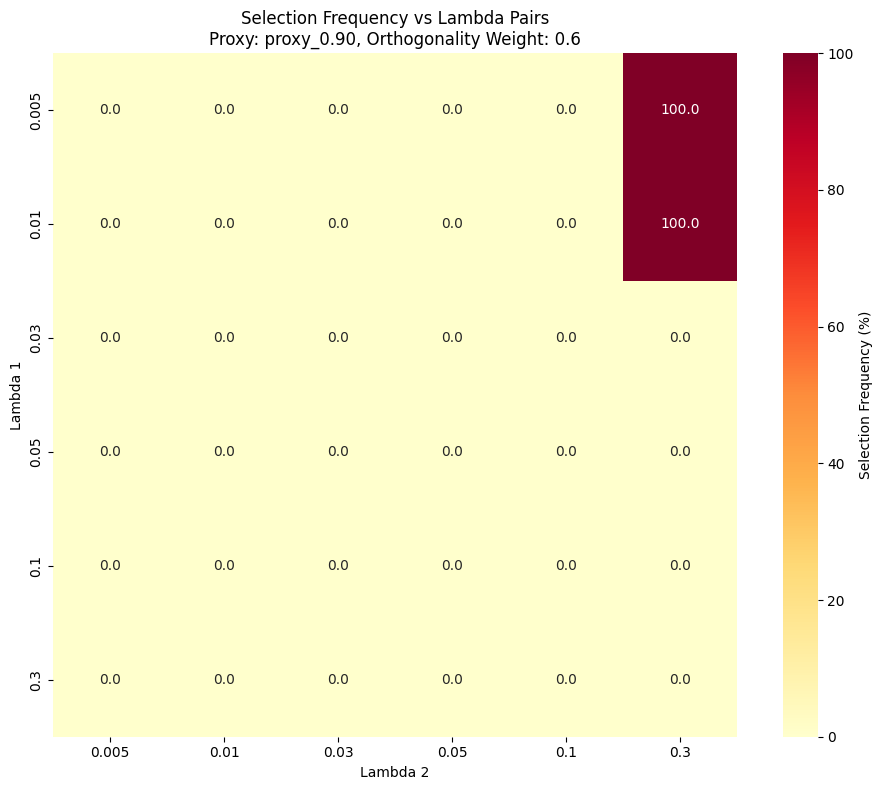

In [ ]:
df = pd.read_stata("/content/temp_yougov.dta")
weight = 0.60
pairs = [(0.001, 0.2), (0.001, 0.3), (0.001, 0.4), (0.001, 0.5), (0.005, 0.2), (0.005, 0.3), (0.005, 0.4), (0.005, 0.5), (0.01, 0.2), (0.01, 0.3), (0.01, 0.4), (0.01, 0.5)]
num_iterations = 7
target_correlation = 0.90
target = 'christian_nationalism'
predictors = [
                   'presvote20post',
                   'housevote20post',
                   'senvote20post',
                   'pff_jb',
                   'pff_dt',
                   'pid7',
                   'election_fairnness',
                   'educ',
                   'hispanic',
                   'partisan_violence',
                   'immigrant_citizenship',
                   'immigrant_deport',
                   'auth_grid_1',
                   'auth_grid_3',
                   'auth_grid_2',
                   'faminc_new']

run_and_visualize_monte_carlo3(df, weight, num_iterations, target, target_correlation, predictors, pairs)

